# Advanced Lane Detection Using Computer Vision

Identifying lanes on the road is a common task performed by all human drivers to ensure their vehicles are within lane constraints when driving, so as to make sure traffic is smooth and minimize chances of collisions with other cars in nearby lanes.

Similarly, it is a critical task for an autonomous vehicle to perform. It turns out that recognising lane markings on roads is possible using well known computer vision techniques. We will cover how to use various techniques to identify and draw the inside road lanes, lane curvature, and even estimate the vehicle position relative to the lane.

This is project 4 of Term 1 of the Udacity Self Driving Car Engineer Nanodegree.

# Calibration And Undistortion

## Camera Calibration

The first step we will take is to find the calibration matrix, along with distortion coefficient for the camera that was used to take pictures of the road. This is necessary because the convex shape of camera lenses curves light rays as the enter the pinhole, therefore causing distortions to the real image. Therefore lines that are straight in the real world may not be anymore on our photos. 

To compute the camera the transformation matrix and distortion coefficients, we use a multiple pictures of a _chessboard_ on a flat surface taken **by the same camera**. OpenCV has a convenient method called [findChessboardCorners](http://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#cv2.findChessboardCorners) that will identify the points where black and white squares intersect and reverse engineer the distorsion matrix this way. 

In [ ]:
# Main imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from importlib import reload
import utilities; reload(utilities)
from utilities import *

In [ ]:
calibration_dir = "camera_cal"
test_imgs_dir = "test_images"
output_imgs_dir = "output_images"
output_videos_dir = "output_videos"

### Finding Chessboard Corners

We must determine the number of inner corners horizontally and vertically for our sample chessboard pictures.

In [ ]:
# Let's get all our calibration image paths
cal_imgs_paths = glob.glob(calibration_dir + "/*.jpg")

In [ ]:
# Let's the first chessboard image to see what it looks like
cal_img_path = cal_imgs_paths[11]
cal_img = load_image(cal_img_path)
plt.imshow(cal_img)

Our chessboard has *9* inner corners in the x direction, and *6* in the y direction. We will use these as parameters to *findChessboardCorners()*.

In [ ]:
cx = 9
cy = 6

We submit grayscale images to _findChessboardCorners_ so we must therefore define a utility method for this purpose.

In [ ]:
def findChessboardCorners(img, nx, ny):
    """
    Finds the chessboard corners of the supplied image (must be grayscale)
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    """
    return cv2.findChessboardCorners(img, (nx, ny), None)        

In [ ]:
def showChessboardCorners(img, nx, ny, ret, corners):
    """
    Draws the chessboard corners of a given image
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    ret and corners should represent the results from cv2.findChessboardCorners()
    """
    c_img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.axis('off')
    plt.imshow(img)

In [ ]:
ret, corners = findChessboardCorners(to_grayscale(cal_img), cx, cy)
showChessboardCorners(cal_img, cx, cy, ret, corners)

We can see that corners are very well identified. Next we identify image and object points to calibrate the camera.

### Image Undistortion

#### Identifying Image And Object Points

We find the mappings for coordinates of the images in 2D space (i.e. *image points*) to those of the undistorted image in the real-world (i.e. *object points*)

In [ ]:
def findImgObjPoints(imgs_paths, nx, ny):
    """
    Returns the objects and image points computed for a set of chessboard pictures taken from the same camera
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    """
    objpts = []
    imgpts = []
    
    # Pre-compute what our object points in the real world should be (the z dimension is 0 as we assume a flat surface)
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    
    for img_path in imgs_paths:
        img = load_image(img_path)
        gray = to_grayscale(img)
        ret, corners = findChessboardCorners(gray, nx, ny)
        
        if ret:
            # Found the corners of an image
            imgpts.append(corners)
            # Add the same object point since they don't change in the real world
            objpts.append(objp)
    
    return objpts, imgpts

In [ ]:
opts, ipts = findImgObjPoints(cal_imgs_paths, cx, cy)

#### Finding Calibration Matrix

In [ ]:
def undistort_image(img, objpts, imgpts):
    """
    Returns an undistorted image
    The desired object and image points must also be supplied to this function
    """
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, to_grayscale(img).shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [ ]:
cal_img_example = load_image(cal_imgs_paths[0])
cal_img_undist = undistort_image(cal_img_example, opts, ipts)
fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(cal_img_example)
ax[0].axis("off")
ax[0].set_title("Distorted Image")

ax[1].imshow(cal_img_undist)
ax[1].axis("off")
ax[1].set_title("Undistorted Image")

plt.show()

We can see that the undistortion step indeed works well. Let's apply the undistortion step to our test images.

#### Undistorting Test Images

In [ ]:
test_imgs_paths = glob.glob(test_imgs_dir + "/*.jpg")

In [ ]:
test_img_names = np.asarray(list(map(lambda img_path: img_path.split("/")[-1].split(".")[0], test_imgs_paths)))
undist_test_img_names = np.asarray(list(map(lambda img_name: "{0}{1}".format("undistorted_", img_name), test_img_names)))

In [ ]:
test_imgs = np.asarray(list(map(lambda img_path: load_image(img_path), test_imgs_paths)))
undist_test_imgs = np.asarray(list(map(lambda img: undistort_image(img, opts, ipts), test_imgs)))

In [ ]:
test_img_and_undist = np.asarray(list(zip(test_imgs, undist_test_imgs)))
test_img_and_undist_names = np.asarray(list(zip(test_img_names, undist_test_img_names)))

In [ ]:
show_image_list(test_img_and_undist, test_img_and_undist_names, "Test Images vs Undistored Images", fig_size=(12, 20), cols=2, show_ticks=False)

The sample above shows original next to undistored images. We can see that on the undistorted images, the front of the car, especially at the sides, is less visible.

## Thresholding

We apply color and edge  thresholding in this section to better detect the lines, and make it easier to find the polynomial that best describes our left and right lanes later. 

We start with first exploring which color spaces we should adopt to increase our chances of detecting the lanes and facilitating the task of the gradient thresholding step.

In [ ]:
def threshold_img(img, channel, thres=(0, 255)):
    """
    Applies a threshold mask to the input image
    """
    img_ch = img[:,:,channel]
    if thres is None:  
        return img_ch
    
    mask_ch = np.zeros_like(img_ch)
    mask_ch[ (thres[0] <= img_ch) & (thres[1] >= img_ch) ] = 1
    return mask_ch

In [ ]:
test_img_path = test_imgs_paths[7]
test_img = load_image(test_img_path)
undistorted_test_img = undistort_image(test_img, opts, ipts)

### Color Thresholding

We experiment with different color spaces and try out some thresolding values to identify the best parameters and most suitable color space and channel to pick.

In [ ]:
rgb_comp = np.asarray([[threshold_img(undistorted_test_img, 0, thres=None), threshold_img(undistorted_test_img, 1, thres=None), threshold_img(undistorted_test_img, 2, thres=None)]])
rgb_lbs = np.asarray([["Red Channel", "Green Channel", "Blue Channel"]])

In [ ]:
hls_test_img = to_hls(undistorted_test_img)
hls_comp = np.asarray([[threshold_img(hls_test_img, 0, thres=None), threshold_img(hls_test_img, 1, thres=None), threshold_img(hls_test_img, 2, thres=None)]])
hls_lbs = np.asarray([["Hue Channel", "Lightness Channel", "Saturation Channel"]])

In [ ]:
hsv_test_img = to_hsv(undistorted_test_img)
hsv_comp = np.asarray([[threshold_img(hsv_test_img, 0, thres=None), threshold_img(hsv_test_img, 1, thres=None), threshold_img(hsv_test_img, 2, thres=None)]])
hsv_lbs = np.asarray([["Hue Channel", "Saturation Channel", "Value Channel"]])

In [ ]:
lab_test_img = to_lab(undistorted_test_img)
lab_comp = np.asarray([[threshold_img(lab_test_img, 0, thres=None), threshold_img(lab_test_img, 1, thres=None), threshold_img(lab_test_img, 2, thres=None)]])
lab_lbs = np.asarray([["Lightness Channel", "Green-Red (A) Channel", "Blue-Yellow (B) Channel"]])

In [ ]:
color_spaces_comps = np.concatenate((rgb_comp, hls_comp, hsv_comp, lab_comp))
color_spaces_lbs = np.concatenate((rgb_lbs, hls_lbs, hsv_lbs, lab_lbs))

In [ ]:
show_image_list(color_spaces_comps, color_spaces_lbs, "Color Channels: RGB - HLS - HSV - LAB", cols=3, fig_size=(15, 10), show_ticks=False)

On the RGB components, we see that the blue channel is worst at identifying yellow lines, while the red channel seems to give best results.

For HLS and HSV, the hue channel produces an extremely noisy output, while the saturation channel of HLS seems to give the strong results; better than HSV's saturation channel. conversely, HSV's value channel is giving a very clear grayscale-ish image, especially on the yellow line, much better than HLS' lightness channel.

Lastly, LAB's A channel is not doing a great job, while it's B channel is strong at identifying the yellow line. But it is the lightness channel that shines (no pun intended) at identify both yellow and white lines.

At this stage, we are faced with various choices that have pros and cons. Our goal here is to find the right thresholds on a given color channel to highlight yellow and white lines of the lane. There are actually many ways we could achieve this result, but **we choose to use HLS because we already know how to set thresholds for yellow and white lane lines from [Project 1](https://github.com/kenshiro-o/CarND-LaneLines-P1)** .

In [ ]:
def compute_hls_white_yellow_binary(rgb_img):
    """
    Returns a binary thresholded image produced retaining only white and yellow elements on the picture
    The provided image should be in RGB format
    """
    hls_img = to_hls(rgb_img)
    
    # Compute a binary thresholded image where yellow is isolated from HLS components
    img_hls_yellow_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_yellow_bin[((hls_img[:,:,0] >= 15) & (hls_img[:,:,0] <= 35))
                 & ((hls_img[:,:,1] >= 30) & (hls_img[:,:,1] <= 204))
                 & ((hls_img[:,:,2] >= 115) & (hls_img[:,:,2] <= 255))                
                ] = 1
    
    # Compute a binary thresholded image where white is isolated from HLS components
    img_hls_white_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_white_bin[((hls_img[:,:,0] >= 0) & (hls_img[:,:,0] <= 255))
                 & ((hls_img[:,:,1] >= 200) & (hls_img[:,:,1] <= 255))
                 & ((hls_img[:,:,2] >= 0) & (hls_img[:,:,2] <= 255))                
                ] = 1
    
    # Now combine both
    img_hls_white_yellow_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_white_yellow_bin[(img_hls_yellow_bin == 1) | (img_hls_white_bin == 1)] = 1

    return img_hls_white_yellow_bin

In [ ]:
undistorted_yellow_white_hls_img_bin = compute_hls_white_yellow_binary(undistorted_test_img)

fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(undistorted_test_img)
ax[0].axis("off")
ax[0].set_title("Undistorted Image")

ax[1].imshow(undistorted_yellow_white_hls_img_bin, cmap='gray')
ax[1].axis("off")
ax[1].set_title("HLS Color Thresholded Image")

plt.show()

As you can see above, our HLS color thresholding achieve great results on the image. The thresholding somewhat struggles a little with the shadow of the tree on the yellow line further up ahead. We believe gradient thresholding can help in this case.

### Gradient Thresholding Via Sobel

We use the [Sobel](https://en.wikipedia.org/wiki/Sobel_operator) operator to identify _gradients_, that is change in _color intensity_ in the image. Higher values would denote strong gradients, and therefore sharp changes in color.

We have decided to use LAB's L channel as our single-channel image to serve as input to the sobel functions below.

In [ ]:
# L channel is index 0 of the color components
undist_test_img_gray = to_lab(undistorted_test_img)[:,:,0]

#### Sobel In X or Y Directions

In [ ]:
def abs_sobel(gray_img, x_dir=True, kernel_size=3, thres=(0, 255)):
    """
    Applies the sobel operator to a grayscale-like (i.e. single channel) image in either horizontal or vertical direction
    The function also computes the asbolute value of the resulting matrix and applies a binary threshold
    """
    sobel = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size) if x_dir else cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size) 
    sobel_abs = np.absolute(sobel)
    sobel_scaled = np.uint8(255 * sobel / np.max(sobel_abs))
    
    gradient_mask = np.zeros_like(sobel_scaled)
    gradient_mask[(thres[0] <= sobel_scaled) & (sobel_scaled <= thres[1])] = 1
    return gradient_mask

In [ ]:
sobx_3x3_thres = np.asarray([[abs_sobel(undist_test_img_gray, thres=(20, 120)), abs_sobel(undist_test_img_gray, thres=(50, 150)), abs_sobel(undist_test_img_gray, thres=(80, 200))]])
sobx_7x7_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=7, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=7, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=7, thres=(80, 200))]])
sobx_11x11_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=11, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=11, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=11, thres=(80, 200))]])
sobx_15x15_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=15, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))]])

sobx_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,120)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
sobx_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,120)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
sobx_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,120)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
sobx_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,120)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])


In [ ]:
sobx_thres = np.concatenate((sobx_3x3_thres, sobx_7x7_thres, sobx_11x11_thres, sobx_15x15_thres))
sobx_thres_lbs = np.concatenate((sobx_3x3_thres_lbs, sobx_7x7_thres_lbs, sobx_11x11_thres_lbs, sobx_15x15_thres_lbs))

In [ ]:
show_image_list(sobx_thres, sobx_thres_lbs, "Sobel (X Direction) Thresholds", cols=3, show_ticks=False)

We obtain the "best" results for Sobel in the X direction with thresholds values between in the interval _[20,120]_, using a kernel size of 15 (lines are very crisp).

In [ ]:
# Saving our best sobel results
sobx_best = abs_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 120))

In [ ]:
soby_3x3_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, thres=(80, 200))]])
soby_7x7_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(80, 200))]])
soby_11x11_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(80, 200))]])
soby_15x15_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(80, 200))]])

soby_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,120)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
soby_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,120)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
soby_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,120)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
soby_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,120)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])


In [ ]:
soby_thres = np.concatenate((soby_3x3_thres, soby_7x7_thres, soby_11x11_thres, soby_15x15_thres))
soby_thres_lbs = np.concatenate((soby_3x3_thres_lbs, soby_7x7_thres_lbs, soby_11x11_thres_lbs, soby_15x15_thres_lbs))

In [ ]:
show_image_list(soby_thres, soby_thres_lbs, "Sobel (Y Direction) Thresholds", cols=3, show_ticks=False)

In the Y direction, our best Sobel configuration is with thresholds in the interval _[20,120]_ and kernel size 15.

In [38]:
# Saving our best sobel y result
soby_best = abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(20, 120))

#### Sobel Magnitude in X and Y Directions

In [39]:
def mag_sobel(gray_img, kernel_size=3, thres=(0, 255)):
    """
    Computes sobel matrix in both x and y directions, merges them by computing the magnitude in both directions
    and applies a threshold value to only set pixels within the specified range
    """
    sx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sy = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size)
    
    sxy = np.sqrt(np.square(sx) + np.square(sy))
    scaled_sxy = np.uint8(255 * sxy / np.max(sxy))
    
    sxy_binary = np.zeros_like(scaled_sxy)
    sxy_binary[(scaled_sxy >= thres[0]) & (scaled_sxy <= thres[1])] = 1
    
    return sxy_binary

In [40]:
sobxy_3x3_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=3, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=3, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=3, thres=(80, 200))]])
sobxy_7x7_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=7, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=7, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=7, thres=(80, 200))]])
sobxy_11x11_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=11, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=11, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=11, thres=(80, 200))]])
sobxy_15x15_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=15, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))]])

sobxy_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,80)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
sobxy_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,80)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
sobxy_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,80)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
sobxy_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,80)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])


In [41]:
sobxy_thres = np.concatenate((sobxy_3x3_thres, sobxy_7x7_thres, sobxy_11x11_thres, sobxy_15x15_thres))
sobxy_thres_lbs = np.concatenate((sobxy_3x3_thres_lbs, sobxy_7x7_thres_lbs, sobxy_11x11_thres_lbs, sobxy_15x15_thres_lbs))


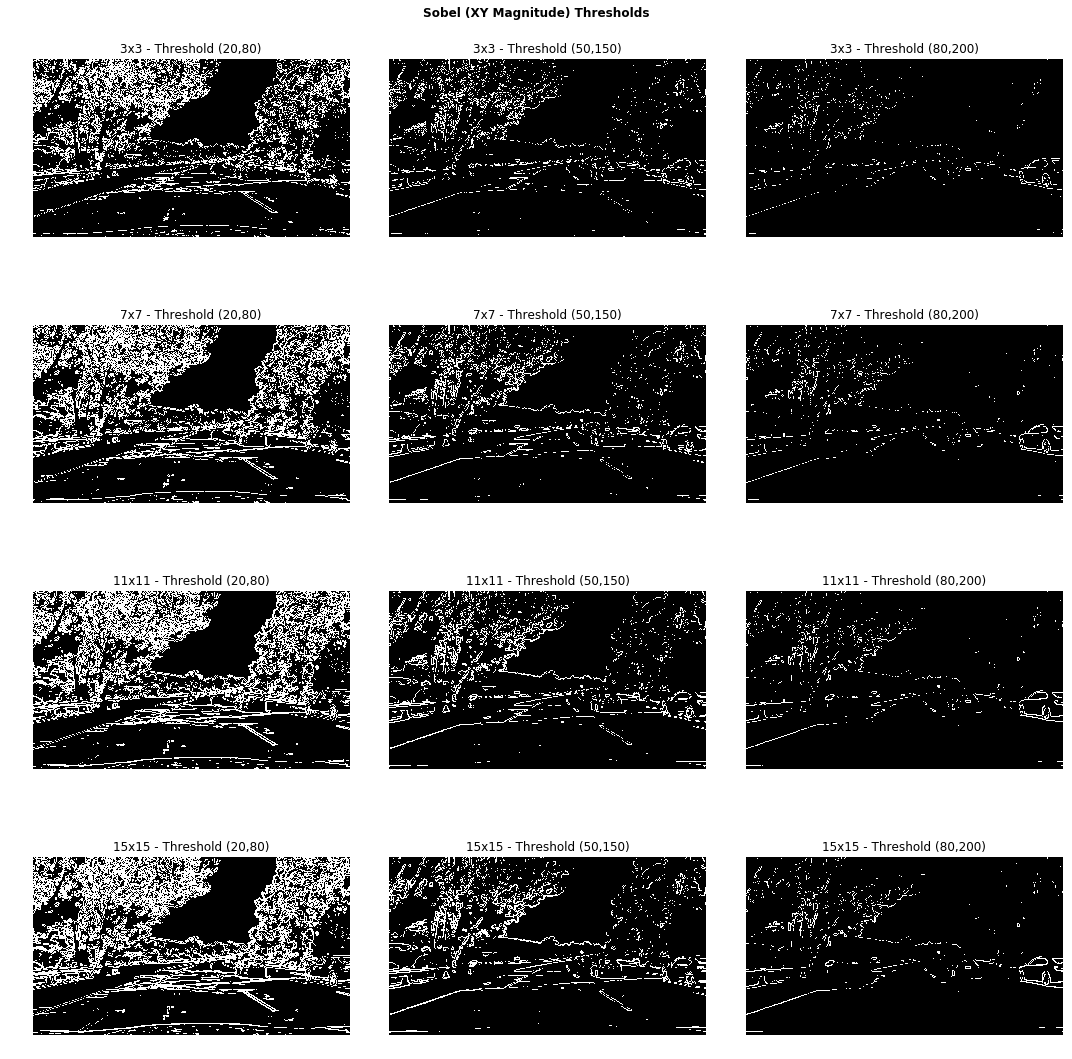

In [42]:
show_image_list(sobxy_thres, sobxy_thres_lbs, "Sobel (XY Magnitude) Thresholds", cols=3, show_ticks=False)

Since we plan to combine this Sobel result, we believe we get enough information for interval _[80, 200]_ and kernel size 15.

In [43]:
# Saving our best Sobel XY magnitude results
sobxy_best = mag_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))

#### Sobel With Gradient Direction

This Sobel operation is extremely noisy and it becomes quite hard to decipher the result if we do not combine it with our previous sobel operations and produce a binary output.

In [44]:
def dir_sobel(gray_img, kernel_size=3, thres=(0, np.pi/2)):
    """
    Computes sobel matrix in both x and y directions, gets their absolute values to find the direction of the gradient
    and applies a threshold value to only set pixels within the specified range
    """
    sx_abs = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size))
    sy_abs = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size))
    
    dir_sxy = np.arctan2(sx_abs, sy_abs)

    binary_output = np.zeros_like(dir_sxy)
    binary_output[(dir_sxy >= thres[0]) & (dir_sxy <= thres[1])] = 1
    
    return binary_output

In [45]:
def combined_sobels(sx_binary, sy_binary, sxy_magnitude_binary, gray_img, kernel_size=3, angle_thres=(0, np.pi/2)):
    sxy_direction_binary = dir_sobel(gray_img, kernel_size=kernel_size, thres=angle_thres)
    
    combined = np.zeros_like(sxy_direction_binary)
    # Sobel X returned the best output so we keep all of its results. We perform a binary and on all the other sobels    
    combined[(sx_binary == 1) | ((sy_binary == 1) & (sxy_magnitude_binary == 1) & (sxy_direction_binary == 1))] = 1
    
    return combined

In [46]:
cb = combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray)

In [47]:
sobxy_combined_dir_3x3_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_7x7_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_11x11_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_15x15_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/3, np.pi/2))
                                           ]])


sobxy_combined_dir_3x3_thres_lbs = np.asarray([["3x3 - Combined (0, pi/4)", "3x3 - Combined (pi/4, pi/2)", "3x3 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_7x7_thres_lbs = np.asarray([["7x7 - Combined (0, pi/4)", "7x7 - Combined (pi/4, pi/2)", "7x7 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_11x11_thres_lbs = np.asarray([["11x11 - Combined (0, pi/4)", "11x11 - Combined (pi/4, pi/2)", "11x11 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_15x15_thres_lbs = np.asarray([["15x15 - Combined (0, pi/4)", "15x15 - Combined (pi/4, pi/2)", "15x15 - Combined (pi/3, pi/2)"]])

In [48]:
sobxy_combined_dir_thres = np.concatenate((sobxy_combined_dir_3x3_thres, sobxy_combined_dir_7x7_thres, sobxy_combined_dir_11x11_thres, sobxy_combined_dir_15x15_thres))
sobxy_combined_dir_thres_lbs = np.concatenate((sobxy_combined_dir_3x3_thres_lbs, sobxy_combined_dir_7x7_thres_lbs, sobxy_combined_dir_11x11_thres_lbs, sobxy_combined_dir_15x15_thres_lbs))

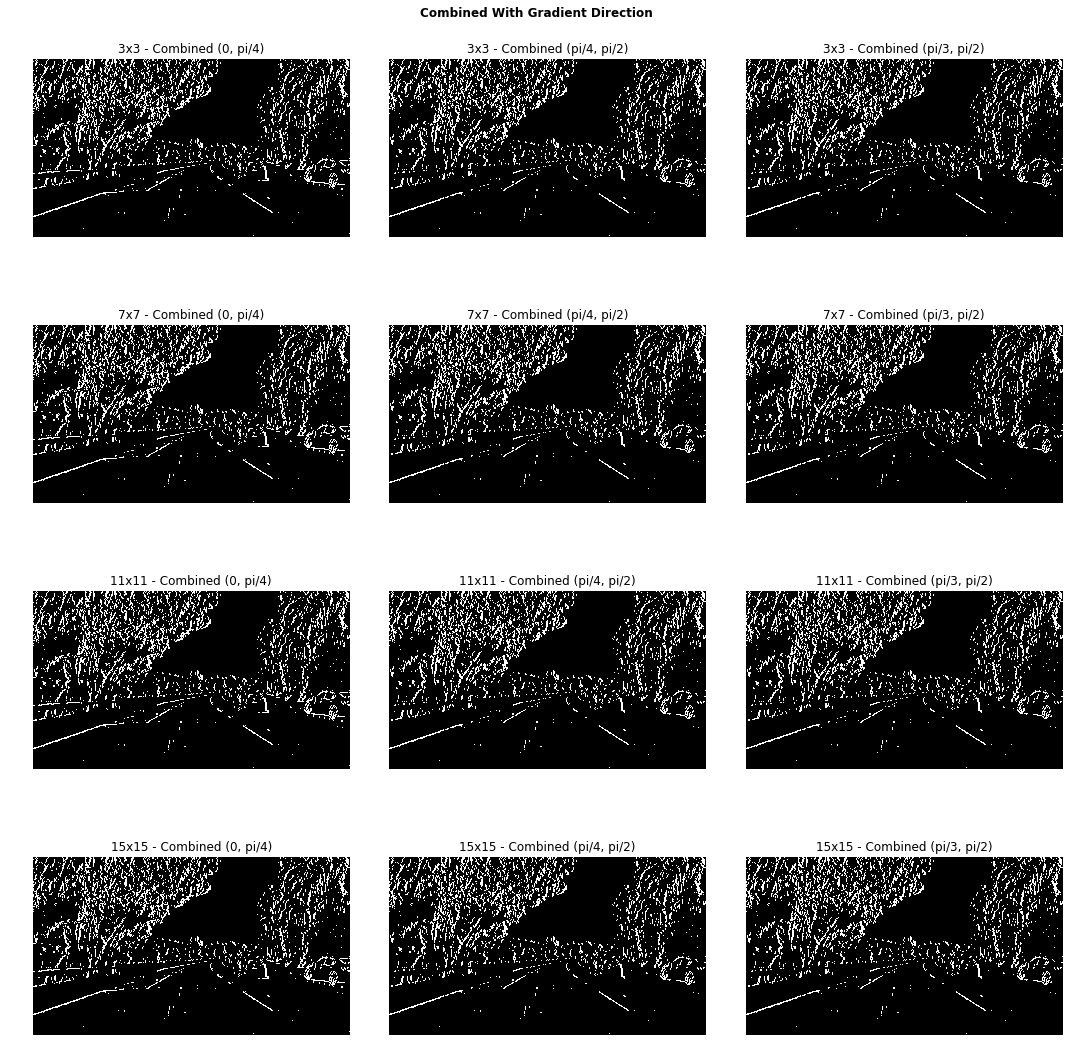

In [49]:
show_image_list(sobxy_combined_dir_thres, sobxy_combined_dir_thres_lbs, "Combined With Gradient Direction", cols=3, show_ticks=False)

Interestingly, the kernel size does not seem to affect the direction sobel operation so much. It's also hard to determine which one is the "best" result out of all our visualisations. Since we want to retain only information about lane lines, we are inclined to elect interval _[pi/4, pi/2]_ as our best configuration as it gives us the most room for manoeuvre. Kernel size of 15x15 produces the least noise.

In [50]:
sobel_combined_best = combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2))                                                                            

The resulting image from combined variant of sobel operations shows promise. We should next combine it with the results we obtained from our HLS' color thresholding method.

### Combining Color And Gradient (Sobel) Thresholds

In [51]:
color_binary = np.dstack((np.zeros_like(sobel_combined_best), sobel_combined_best, undistorted_yellow_white_hls_img_bin)) * 255
color_binary = color_binary.astype(np.uint8)

In [52]:
combined_binary = np.zeros_like(undistorted_yellow_white_hls_img_bin)
combined_binary[(sobel_combined_best == 1) | (undistorted_yellow_white_hls_img_bin == 1)] = 1

In [53]:
combined_binaries = [[color_binary, combined_binary]]
combined_binaries_lbs = np.asarray([["Stacked Thresholds", "Combined Color And Gradient Thresholds"]])

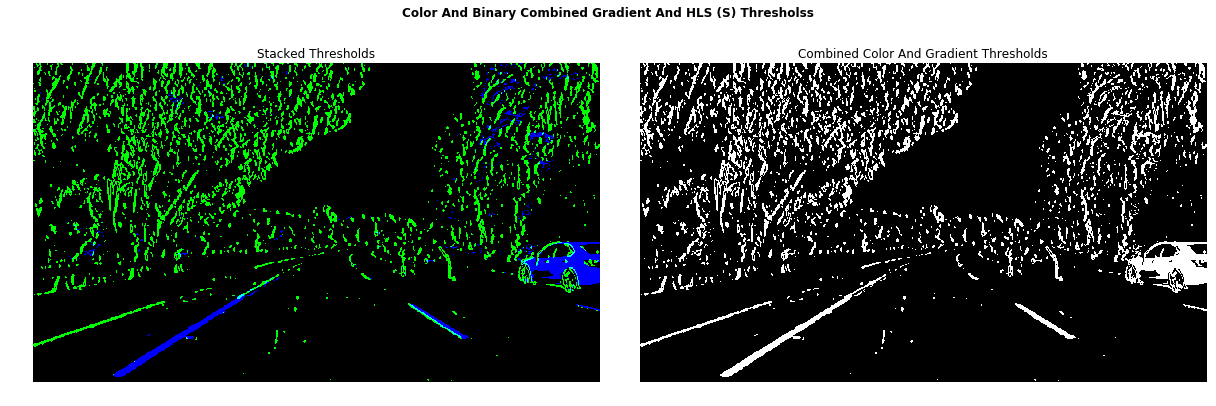

In [54]:
show_image_list(combined_binaries, combined_binaries_lbs, "Color And Binary Combined Gradient And HLS (S) Thresholss", cols=2, fig_size=(17, 6), show_ticks=False)

The results are very encouraging and it seems we have found the right parameters to detect lanes in a robust manner. We turn next to applying a perspective transform to our image and produce a _bird's eye view_ of the lane.

## Perspective Transform

We now need to define a trapezoidal region in the 2D image that will go through a perspective transform to convert into a bird's eye view.

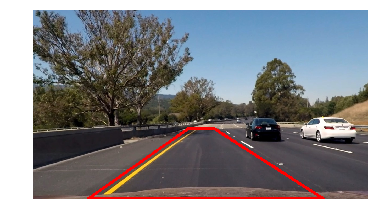

In [55]:
copy_combined = np.copy(undist_test_imgs[1])
(bottom_px, right_px) = (copy_combined.shape[0] - 1, copy_combined.shape[1] - 1) 
pts = np.array([[210,bottom_px],[595,450],[690,450], [1110, bottom_px]], np.int32)
cv2.polylines(copy_combined,[pts],True,(255,0,0), 10)
plt.axis('off')
plt.imshow(copy_combined)

In [56]:
def compute_perspective_transform_matrices(src, dst):
    """
    Returns the tuple (M, M_inv) where M represents the matrix to use for perspective transform
    and M_inv is the matrix used to revert the transformed image back to the original one
    """
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    
    return (M, M_inv)

In [57]:
def perspective_transform(img, src, dst):   
    """
    Applies a perspective 
    """
    M = cv2.getPerspectiveTransform(src, dst)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

In [58]:
src_pts = pts.astype(np.float32)
dst_pts = np.array([[200, bottom_px], [200, 0], [1000, 0], [1000, bottom_px]], np.float32)

In [59]:
test_img_persp_tr = perspective_transform(undistorted_test_img, src_pts, dst_pts)

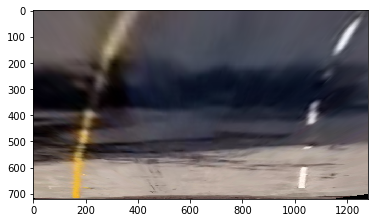

In [60]:
plt.imshow(test_img_persp_tr)

Here the lane is curved, and our perspective transform takes this into account too.

In [61]:
test_imgs_pers_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), undist_test_imgs))) 

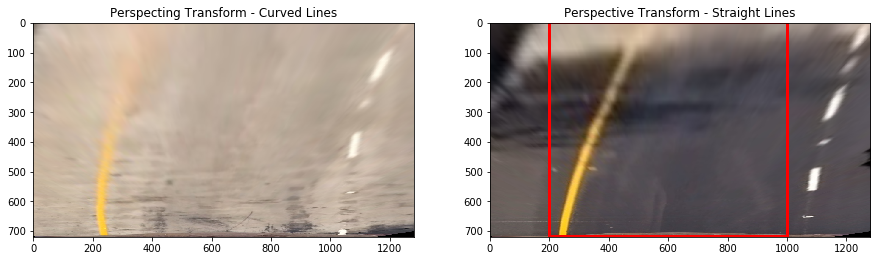

In [62]:
test_persp_img = np.copy(test_imgs_pers_tr[1])
dst = dst_pts.astype(np.int32)
cv2.polylines(test_persp_img,[dst],True,(255,0,0), 10)

fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(test_imgs_pers_tr[5])
ax[0].set_title("Perspecting Transform - Curved Lines")

ax[1].imshow(test_persp_img)
ax[1].set_title("Perspective Transform - Straight Lines")

plt.show()

We can see that our perspective transform keeps straight lines straight, which is a required sanity check. The curved lines however are not perfect on the example above, but they should not cause unsurmountable problems for our algorithm either. 

In [63]:
test_undist_imgs_and_p_tr = np.asarray(list(zip(undist_test_imgs, test_imgs_pers_tr)))
test_undist_imgs_and_p_tr_names = np.asarray(list(zip(undist_test_img_names, undist_test_img_names)))

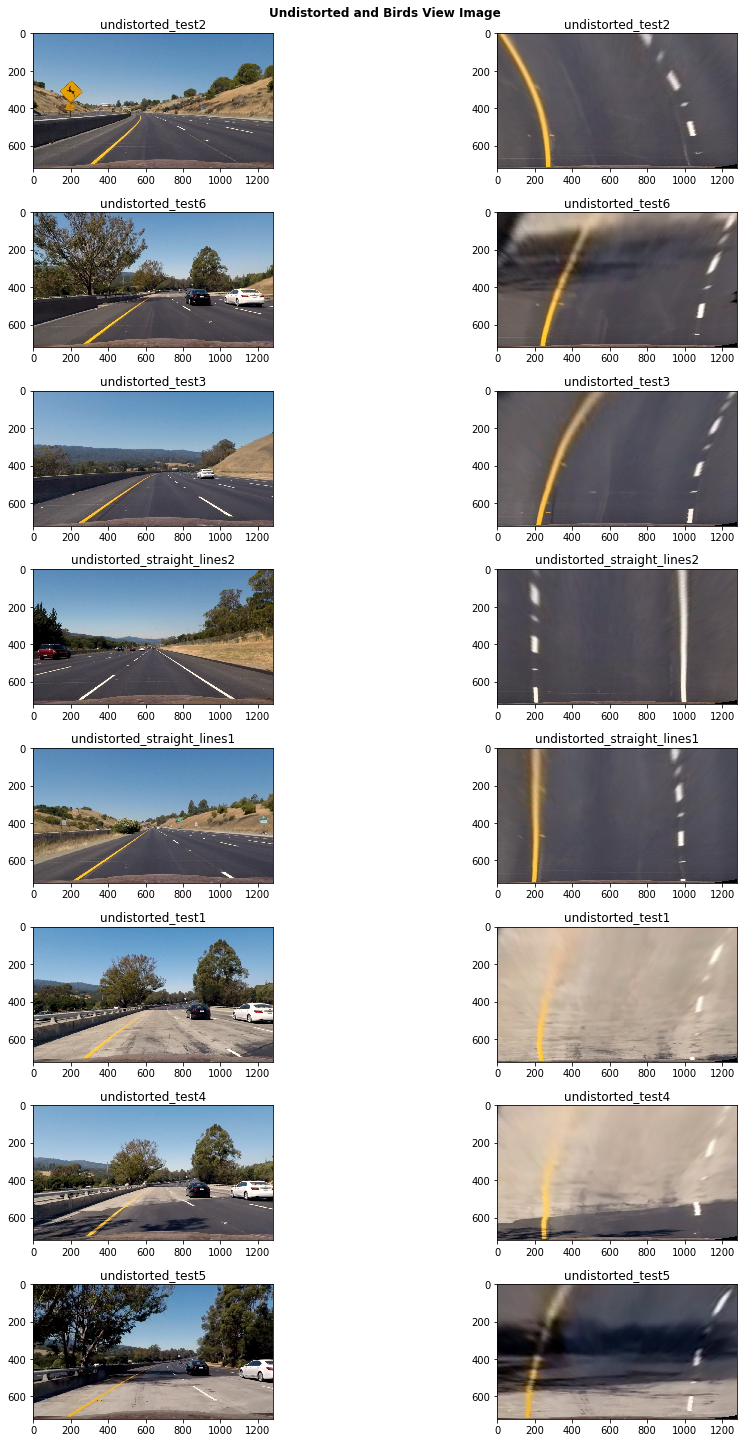

In [64]:
show_image_list(test_undist_imgs_and_p_tr, test_undist_imgs_and_p_tr_names, "Undistorted and Birds View Image", fig_size=(15, 20))

At this stage it is fitting to start definining a pipeline of operations to perform and visualise perspective transform on thresholding binary images.

### Putting It All Together

In [65]:
def get_combined_binary_thresholded_img(undist_img):
    """
    Applies a combination of binary Sobel and color thresholding to an undistorted image
    Those binary images are then combined to produce the returned binary image
    """
    undist_img_gray = to_lab(undist_img)[:,:,0]
    sx = abs_sobel(undist_img_gray, kernel_size=15, thres=(20, 120))
    sy = abs_sobel(undist_img_gray, x_dir=False, kernel_size=15, thres=(20, 120))
    sxy = mag_sobel(undist_img_gray, kernel_size=15, thres=(80, 200))
    sxy_combined_dir = combined_sobels(sx, sy, sxy, undist_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2))   
    
    hls_w_y_thres = compute_hls_white_yellow_binary(undist_img)
    
    combined_binary = np.zeros_like(hls_w_y_thres)
    combined_binary[(sxy_combined_dir == 1) | (hls_w_y_thres == 1)] = 1
        
    return combined_binary

In [66]:
test_imgs_combined_binary_thres = np.asarray(list(map(lambda img: get_combined_binary_thresholded_img(img), undist_test_imgs)))

In [67]:
test_imgs_psp_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), undist_test_imgs))) 

In [68]:
test_imgs_combined_binary_psp_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), test_imgs_combined_binary_thres))) 

In [69]:
test_imgs_combined_binary_and_psp_tr = np.asarray(list(zip(test_imgs_psp_tr[:,:,:,0],test_imgs_combined_binary_thres, test_imgs_combined_binary_psp_tr)))
test_imgs_combined_binary_and_psp_tr_names = np.asarray(list(zip(undist_test_img_names,undist_test_img_names, undist_test_img_names)))

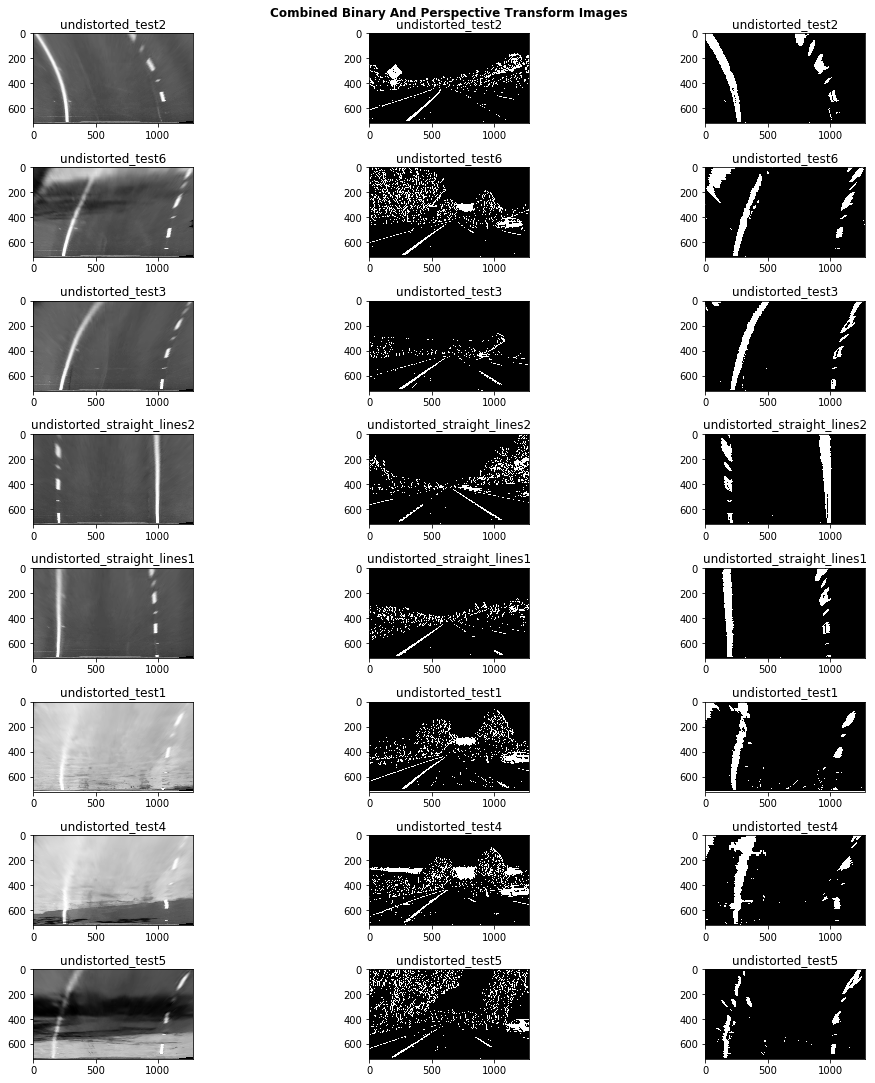

In [70]:
show_image_list(test_imgs_combined_binary_and_psp_tr, test_imgs_combined_binary_and_psp_tr_names, "Combined Binary And Perspective Transform Images", cols=3, fig_size=(15, 15))

The perspective transform, then application of color and gradient thresholding enable us to clearly identify the position of the lanes on the bird's eye view image. However, we also notice some small dots and other visual artifacts. We must build a robust lane finder in order not to be caught by these glitches.

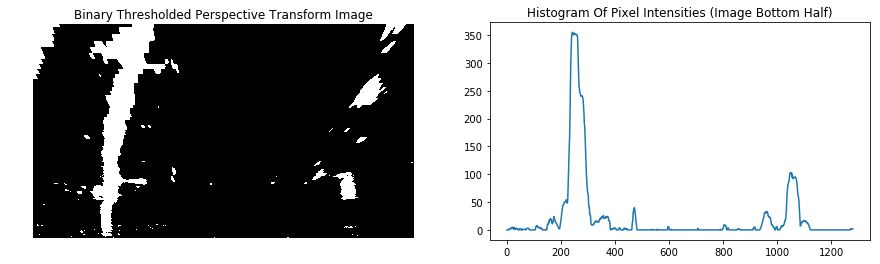

In [71]:
img_example = test_imgs_combined_binary_and_psp_tr[6][2]
histogram = np.sum(img_example[img_example.shape[0]//2:,:], axis=0)

fig, ax = plt.subplots(1, 2, figsize=(15,4))
ax[0].imshow(img_example, cmap='gray')
ax[0].axis("off")
ax[0].set_title("Binary Thresholded Perspective Transform Image")

ax[1].plot(histogram)
ax[1].set_title("Histogram Of Pixel Intensities (Image Bottom Half)")

plt.show()

# Pipeline Definition

Let's now define our full pipeline for lane detection on video frames. We will use Python classes to encapsulate a information and use it across frames. 

In [72]:
from collections import deque

def create_queue(length = 10):
    return deque(maxlen=length)

In [73]:
class LaneLine:
    def __init__(self):
        
        self.polynomial_coeff = None
        self.line_fit_x = None
        self.non_zero_x = []
        self.non_zero_y = []
        self.windows = []

In [74]:
import math

class LaneLineHistory:
    def __init__(self, queue_depth=2, test_points=[50, 300, 500, 700], poly_max_deviation_distance=150):
        self.lane_lines = create_queue(queue_depth)
        self.smoothed_poly = None
        self.test_points = test_points
        self.poly_max_deviation_distance = poly_max_deviation_distance
    
    def append(self, lane_line, force=False):
        if len(self.lane_lines) == 0 or force:
            self.lane_lines.append(lane_line)
            self.get_smoothed_polynomial()
            return True
        
        test_y_smooth = np.asarray(list(map(lambda x: self.smoothed_poly[0] * x**2 + self.smoothed_poly[1] * x + self.smoothed_poly[2], self.test_points)))
        test_y_new = np.asarray(list(map(lambda x: lane_line.polynomial_coeff[0] * x**2 + lane_line.polynomial_coeff[1] * x + lane_line.polynomial_coeff[2], self.test_points)))
        
        dist = np.absolute(test_y_smooth - test_y_new)
        
        #dist = np.absolute(self.smoothed_poly - lane_line.polynomial_coeff)
        #dist_max = np.absolute(self.smoothed_poly * self.poly_max_deviation_distance)
        max_dist = dist[np.argmax(dist)]
        
        if max_dist > self.poly_max_deviation_distance:
            print("**** MAX DISTANCE BREACHED ****")
            print("y_smooth={0} - y_new={1} - distance={2} - max-distance={3}".format(test_y_smooth, test_y_new, max_dist, self.poly_max_deviation_distance))
            return False
        
        self.lane_lines.append(lane_line)
        self.get_smoothed_polynomial()
        
        return True
    
    def get_smoothed_polynomial(self):
        all_coeffs = np.asarray(list(map(lambda lane_line: lane_line.polynomial_coeff, self.lane_lines)))
        self.smoothed_poly = np.mean(all_coeffs, axis=0)
        
        return self.smoothed_poly
                                
        

In [75]:
class AdvancedLaneDetectorWithMemory:
    """
    The AdvancedLaneDetectorWithMemory is a class that can detect lines on the road
    """
    def __init__(self, objpts, imgpts, psp_src, psp_dst, sliding_windows_per_line, 
                 sliding_window_half_width, sliding_window_recenter_thres, 
                 small_img_size=(256, 144), small_img_x_offset=20, small_img_y_offset=10,
                 img_dimensions=(720, 1280), lane_width_px=800, 
                 lane_center_px_psp=600, real_world_lane_size_meters=(32, 3.7)):
        self.objpts = objpts
        self.imgpts = imgpts
        (self.M_psp, self.M_inv_psp) = compute_perspective_transform_matrices(psp_src, psp_dst)

        self.sliding_windows_per_line = sliding_windows_per_line
        self.sliding_window_half_width = sliding_window_half_width
        self.sliding_window_recenter_thres = sliding_window_recenter_thres
        
        self.small_img_size = small_img_size
        self.small_img_x_offset = small_img_x_offset
        self.small_img_y_offset = small_img_y_offset
        
        self.img_dimensions = img_dimensions
        self.lane_width_px = lane_width_px
        self.lane_center_px_psp = lane_center_px_psp 
        self.real_world_lane_size_meters = real_world_lane_size_meters

        # We can pre-compute some data here
        self.ym_per_px = self.real_world_lane_size_meters[0] / self.img_dimensions[0]
        self.xm_per_px = self.real_world_lane_size_meters[1] / self.lane_width_px
        self.ploty = np.linspace(0, self.img_dimensions[0] - 1, self.img_dimensions[0])
        
        self.previous_left_lane_line = None
        self.previous_right_lane_line = None
        
        self.previous_left_lane_lines = LaneLineHistory()
        self.previous_right_lane_lines = LaneLineHistory()
        
        self.total_img_count = 0
        
    
    def process_image(self, img):
        """
        Attempts to find lane lines on the given image and returns an image with lane area colored in green
        as well as small intermediate images overlaid on top to understand how the algorithm is performing
        """
        # First step - undistort the image using the instance's object and image points
        undist_img = undistort_image(img, self.objpts, self.imgpts)
        
        # Produce binary thresholded image from color and gradients
        thres_img = get_combined_binary_thresholded_img(undist_img)
        
        # Create the undistorted and binary perspective transforms
        img_size = (undist_img.shape[1], undist_img.shape[0])
        undist_img_psp = cv2.warpPerspective(undist_img, self.M_psp, img_size, flags=cv2.INTER_LINEAR)
        thres_img_psp = cv2.warpPerspective(thres_img, self.M_psp, img_size, flags=cv2.INTER_LINEAR)
        
        ll, rl = self.compute_lane_lines(thres_img_psp)
        lcr, rcr, lco = self.compute_lane_curvature(ll, rl)

        drawn_lines = self.draw_lane_lines(thres_img_psp, ll, rl)        
        #plt.imshow(drawn_lines)
        
        drawn_lines_regions = self.draw_lane_lines_regions(thres_img_psp, ll, rl)
        #plt.imshow(drawn_lines_regions)
        
        drawn_lane_area = self.draw_lane_area(thres_img_psp, undist_img, ll, rl)        
        #plt.imshow(drawn_lane_area)
        
        drawn_hotspots = self.draw_lines_hotspots(thres_img_psp, ll, rl)
        
        combined_lane_img = self.combine_images(drawn_lane_area, drawn_lines, drawn_lines_regions, drawn_hotspots, undist_img_psp)
        final_img = self.draw_lane_curvature_text(combined_lane_img, lcr, rcr, lco)
        
        self.total_img_count += 1
        self.previous_left_lane_line = ll
        self.previous_right_lane_line = rl
        
        return final_img
    
    def draw_lane_curvature_text(self, img, left_curvature_meters, right_curvature_meters, center_offset_meters):
        """
        Returns an image with curvature information inscribed
        """
        
        offset_y = self.small_img_size[1] * 1 + self.small_img_y_offset * 5
        offset_x = self.small_img_x_offset
        
        template = "{0:17}{1:17}{2:17}"
        txt_header = template.format("Left Curvature", "Right Curvature", "Center Alignment") 
        print(txt_header)
        txt_values = template.format("{:.4f}m".format(left_curvature_meters), 
                                     "{:.4f}m".format(right_curvature_meters),
                                     "{:.4f}m Right".format(center_offset_meters))
        if center_offset_meters < 0.0:
            txt_values = template.format("{:.4f}m".format(left_curvature_meters), 
                                     "{:.4f}m".format(right_curvature_meters),
                                     "{:.4f}m Left".format(math.fabs(center_offset_meters)))
            
        
        print(txt_values)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, txt_header, (offset_x, offset_y), font, 1, (255,255,255), 1, cv2.LINE_AA)
        cv2.putText(img, txt_values, (offset_x, offset_y + self.small_img_y_offset * 5), font, 1, (255,255,255), 2, cv2.LINE_AA)
        
        return img
    
    def combine_images(self, lane_area_img, lines_img, lines_regions_img, lane_hotspots_img, psp_color_img):        
        """
        Returns a new image made up of the lane area image, and the remaining lane images are overlaid as
        small images in a row at the top of the the new image
        """
        small_lines = cv2.resize(lines_img, self.small_img_size)
        small_region = cv2.resize(lines_regions_img, self.small_img_size)
        small_hotspots = cv2.resize(lane_hotspots_img, self.small_img_size)
        small_color_psp = cv2.resize(psp_color_img, self.small_img_size)
                
        lane_area_img[self.small_img_y_offset: self.small_img_y_offset + self.small_img_size[1], self.small_img_x_offset: self.small_img_x_offset + self.small_img_size[0]] = small_lines
        
        start_offset_y = self.small_img_y_offset 
        start_offset_x = 2 * self.small_img_x_offset + self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_region
        
        start_offset_y = self.small_img_y_offset 
        start_offset_x = 3 * self.small_img_x_offset + 2 * self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_hotspots

        start_offset_y = self.small_img_y_offset 
        start_offset_x = 4 * self.small_img_x_offset + 3 * self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_color_psp
        
        
        return lane_area_img
    
        
    def draw_lane_area(self, warped_img, undist_img, left_line, right_line):
        """
        Returns an image where the inside of the lane has been colored in bright green
        """
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped_img).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_line.line_fit_x, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.line_fit_x, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, self.M_inv_psp, (undist_img.shape[1], undist_img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
        
        return result
        
        
    def draw_lane_lines(self, warped_img, left_line, right_line):
        """
        Returns an image where the computed lane lines have been drawn on top of the original warped binary image
        """
        # Create an output image with 3 colors (RGB) from the binary warped image to draw on and  visualize the result
        out_img = np.dstack((warped_img, warped_img, warped_img))*255
        
        # Now draw the lines
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        pts_left = np.dstack((left_line.line_fit_x, ploty)).astype(np.int32)
        pts_right = np.dstack((right_line.line_fit_x, ploty)).astype(np.int32)

        cv2.polylines(out_img, pts_left, False,  (255, 140,0), 5)
        cv2.polylines(out_img, pts_right, False, (255, 140,0), 5)
        
        for low_pt, high_pt in left_line.windows:
            cv2.rectangle(out_img, low_pt, high_pt, (0, 255, 0), 3)

        for low_pt, high_pt in right_line.windows:            
            cv2.rectangle(out_img, low_pt, high_pt, (0, 255, 0), 3)           
        
        return out_img    
    
    def draw_lane_lines_regions(self, warped_img, left_line, right_line):
        """
        Returns an image where the computed left and right lane areas have been drawn on top of the original warped binary image
        """
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        margin = self.sliding_window_half_width
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        
        left_line_window1 = np.array([np.transpose(np.vstack([left_line.line_fit_x - margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_line.line_fit_x + margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        
        right_line_window1 = np.array([np.transpose(np.vstack([right_line.line_fit_x - margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_line.line_fit_x + margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Create RGB image from binary warped image
        region_img = np.dstack((warped_img, warped_img, warped_img)) * 255

        # Draw the lane onto the warped blank image
        cv2.fillPoly(region_img, np.int_([left_line_pts]), (0, 255, 0))
        cv2.fillPoly(region_img, np.int_([right_line_pts]), (0, 255, 0))
        
        return region_img


    def draw_lines_hotspots(self, warped_img, left_line, right_line):
        """
        Returns a RGB image where the portions of the lane lines that were
        identified by our pipeline are colored in yellow (left) and blue (right)
        """
        out_img = np.dstack((warped_img, warped_img, warped_img))*255
        
        out_img[left_line.non_zero_y, left_line.non_zero_x] = [255, 255, 0]
        out_img[right_line.non_zero_y, right_line.non_zero_x] = [0, 0, 255]
        
        return out_img

    def compute_lane_curvature(self, left_line, right_line):
        """
        Returns the triple (left_curvature, right_curvature, lane_center_offset), which are all in meters
        """        
        ploty = self.ploty
        y_eval = np.max(ploty)
        # Define conversions in x and y from pixels space to meters
        
        leftx = left_line.line_fit_x
        rightx = right_line.line_fit_x
        
        # Fit new polynomials: find x for y in real-world space
        left_fit_cr = np.polyfit(ploty * self.ym_per_px, leftx * self.xm_per_px, 2)
        right_fit_cr = np.polyfit(ploty * self.ym_per_px, rightx * self.xm_per_px, 2)
        
        # Now calculate the radii of the curvature
        left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * self.ym_per_px + left_fit_cr[1])**2)**1.5) / np.absolute(2 * left_fit_cr[0])
        right_curverad = ((1 + (2 *right_fit_cr[0] * y_eval * self.ym_per_px + right_fit_cr[1])**2)**1.5) / np.absolute(2 * right_fit_cr[0])
        
        # Use our computed polynomial to determine the car's center position in image space, then
        left_fit = left_line.polynomial_coeff
        right_fit = right_line.polynomial_coeff
        
        center_offset_img_space = (((left_fit[0] * y_eval**2 + left_fit[1] * y_eval + left_fit[2]) + 
                   (right_fit[0] * y_eval**2 + right_fit[1] * y_eval + right_fit[2])) / 2) - self.lane_center_px_psp
        center_offset_real_world_m = center_offset_img_space * self.xm_per_px
        
        # Now our radius of curvature is in meters        
        return left_curverad, right_curverad, center_offset_real_world_m
        
        
        
    def compute_lane_lines(self, warped_img):
        """
        Returns the tuple (left_lane_line, right_lane_line) which represents respectively the LaneLine instances for
        the computed left and right lanes, for the supplied binary warped image
        """

        # Take a histogram of the bottom half of the image, summing pixel values column wise 
        histogram = np.sum(warped_img[warped_img.shape[0]//2:,:], axis=0)
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines 
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint # don't forget to offset by midpoint!
        

        # Set height of windows
        window_height = np.int(warped_img.shape[0]//self.sliding_windows_per_line)
        # Identify the x and y positions of all nonzero pixels in the image
        # NOTE: nonzero returns a tuple of arrays in y and x directions
        nonzero = warped_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        total_non_zeros = len(nonzeroy)
        non_zero_found_pct = 0.0
        
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base    


        # Set the width of the windows +/- margin
        margin = self.sliding_window_half_width
        # Set minimum number of pixels found to recenter window
        minpix = self.sliding_window_recenter_thres
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        
        # Our lane line objects we store the result of this computation
        left_line = LaneLine()
        right_line = LaneLine()
                        
        if self.previous_left_lane_line is not None and self.previous_right_lane_line is not None:
            # We have already computed the lane lines polynomials from a previous image
            left_lane_inds = ((nonzerox > (self.previous_left_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                           + self.previous_left_lane_line.polynomial_coeff[1] * nonzeroy 
                                           + self.previous_left_lane_line.polynomial_coeff[2] - margin)) 
                              & (nonzerox < (self.previous_left_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                            + self.previous_left_lane_line.polynomial_coeff[1] * nonzeroy 
                                            + self.previous_left_lane_line.polynomial_coeff[2] + margin))) 

            right_lane_inds = ((nonzerox > (self.previous_right_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                           + self.previous_right_lane_line.polynomial_coeff[1] * nonzeroy 
                                           + self.previous_right_lane_line.polynomial_coeff[2] - margin)) 
                              & (nonzerox < (self.previous_right_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                            + self.previous_right_lane_line.polynomial_coeff[1] * nonzeroy 
                                            + self.previous_right_lane_line.polynomial_coeff[2] + margin))) 
            
            non_zero_found_left = np.sum(left_lane_inds)
            non_zero_found_right = np.sum(right_lane_inds)
            non_zero_found_pct = (non_zero_found_left + non_zero_found_right) / total_non_zeros
           
            print("[Previous lane] Found pct={0}".format(non_zero_found_pct))
            #print(left_lane_inds)
        
        if non_zero_found_pct < 0.85:
            print("Non zeros found below thresholds, begining sliding window - pct={0}".format(non_zero_found_pct))
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(self.sliding_windows_per_line):
                # Identify window boundaries in x and y (and right and left)
                # We are moving our windows from the bottom to the top of the screen (highest to lowest y value)
                win_y_low = warped_img.shape[0] - (window + 1)* window_height
                win_y_high = warped_img.shape[0] - window * window_height

                # Defining our window's coverage in the horizontal (i.e. x) direction 
                # Notice that the window's width is twice the margin
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin

                left_line.windows.append([(win_xleft_low,win_y_low),(win_xleft_high,win_y_high)])
                right_line.windows.append([(win_xright_low,win_y_low),(win_xright_high,win_y_high)])

                # Super crytic and hard to understand...
                # Basically nonzerox and nonzeroy have the same size and any nonzero pixel is identified by
                # (nonzeroy[i],nonzerox[i]), therefore we just return the i indices within the window that are nonzero
                # and can then index into nonzeroy and nonzerox to find the ACTUAL pixel coordinates that are not zero
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
                            
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)

                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices since we now have a list of multiple arrays (e.g. ([1,3,6],[8,5,2]))
            # We want to create a single array with elements from all those lists (e.g. [1,3,6,8,5,2])
            # These are the indices that are non zero in our sliding windows
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
            
            non_zero_found_left = np.sum(left_lane_inds)
            non_zero_found_right = np.sum(right_lane_inds)
            non_zero_found_pct = (non_zero_found_left + non_zero_found_right) / total_non_zeros
           
            print("[Sliding windows] Found pct={0}".format(non_zero_found_pct))
            
    
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
        #print("[LEFT] Number of hot pixels={0}".format(len(leftx)))
        #print("[RIGHT] Number of hot pixels={0}".format(len(rightx)))
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        #print("Poly left {0}".format(left_fit))
        #print("Poly right {0}".format(right_fit))
        left_line.polynomial_coeff = left_fit
        right_line.polynomial_coeff = right_fit
        
        if not self.previous_left_lane_lines.append(left_line):
            left_fit = self.previous_left_lane_lines.get_smoothed_polynomial()
            left_line.polynomial_coeff = left_fit
            self.previous_left_lane_lines.append(left_line, force=True)
            print("**** REVISED Poly left {0}".format(left_fit))            
        #else:
            #left_fit = self.previous_left_lane_lines.get_smoothed_polynomial()
            #left_line.polynomial_coeff = left_fit


        if not self.previous_right_lane_lines.append(right_line):
            right_fit = self.previous_right_lane_lines.get_smoothed_polynomial()
            right_line.polynomial_coeff = right_fit
            self.previous_right_lane_lines.append(right_line, force=True)
            print("**** REVISED Poly right {0}".format(right_fit))
        #else:
            #right_fit = self.previous_right_lane_lines.get_smoothed_polynomial()
            #right_line.polynomial_coeff = right_fit


    
        # Generate x and y values for plotting
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0] )
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
        
        
        left_line.polynomial_coeff = left_fit
        left_line.line_fit_x = left_fitx
        left_line.non_zero_x = leftx  
        left_line.non_zero_y = lefty

        right_line.polynomial_coeff = right_fit
        right_line.line_fit_x = right_fitx
        right_line.non_zero_x = rightx
        right_line.non_zero_y = righty

        
        return (left_line, right_line)

In [76]:
ld = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 100, 50)

In [77]:
proc_img = ld.process_image(test_img)

Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=19388.347281619925
Left Curvature   Right Curvature  Center Alignment 
520.3675m        338.0984m        0.0116m Right    


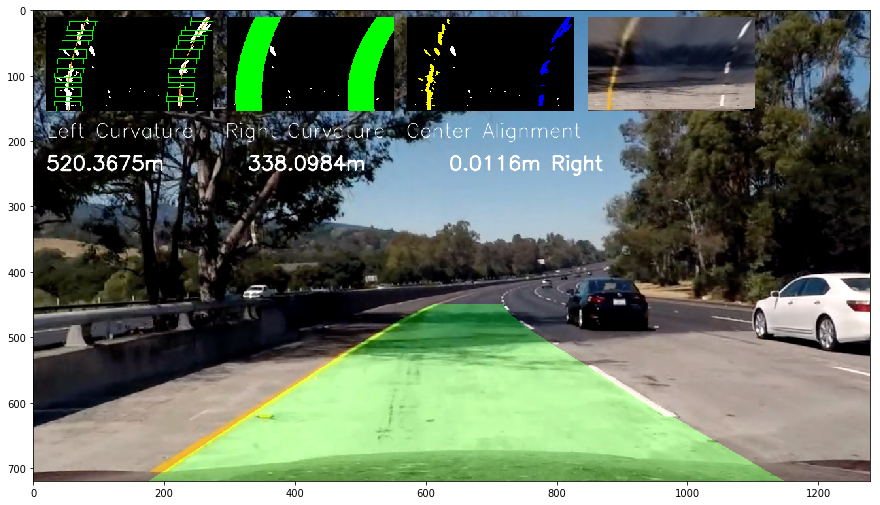

In [78]:
plt.figure(figsize=(15,10))
plt.imshow(proc_img)

In [79]:
#(720, 1280, 3)

# Normal video

In [80]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [81]:
project_video_path = "project_video.mp4"
challenge_video_path = "challenge_video.mp4"
project_video_output_path = 'output_videos/lanes_project_video.mp4'
project_video_sample_path = 'project_video_sample.mp4'
challenge_video_sample_path = 'challenge_video_sample.mp4'

project_video_sample_output_path = 'output_videos/lanes_project_video_sample.mp4'
challenge_video_sample_output_path = 'output_videos/lanes_challenge_video_sample.mp4'

In [85]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
ffmpeg_extract_subclip(project_video_path, 22, 27, targetname=project_video_sample_path)


[MoviePy] Running:
>>> ffmpeg -y -i project_video.mp4 -ss 22.00 -t 5.00 -vcodec copy -acodec copy project_video_sample.mp4
... command successful.


In [ ]:
detector = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 50, 10)
clip1 = VideoFileClip(project_video_sample_path)
project_video_clip = clip1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_sample_output_path, audio=False)

In [ ]:
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(project_video_sample_output_path))

In [ ]:
detector = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 50, 10)

video_clip_1 = VideoFileClip(project_video_path)
project_video_clip = video_clip_1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_output_path, audio=False)

In [ ]:
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(project_video_output_path))

# Challege Videos

In [ ]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
ffmpeg_extract_subclip(challenge_video_path, 0, 4, targetname=challenge_video_sample_path)

In [188]:
detector = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 100, 10)

clip1 = VideoFileClip(challenge_video_sample_path)
challenge_video_clip = clip1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time challenge_video_clip.write_videofile(challenge_video_sample_output_path, audio=False)

Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=18045.79725782213
Left Curvature   Right Curvature  Center Alignment 
101.5201m        173.1180m        0.5088m Left     
[MoviePy] >>>> Building video output_videos/lanes_challenge_video_sample.mp4
[MoviePy] Writing video output_videos/lanes_challenge_video_sample.mp4


  1%|          | 1/121 [00:01<02:21,  1.18s/it]

[Previous lane] Found pct=0.8628911064957872
Left Curvature   Right Curvature  Center Alignment 
108.1833m        167.7179m        0.6357m Left     


  2%|▏         | 2/121 [00:02<02:20,  1.18s/it]

[Previous lane] Found pct=0.8615490196078431
Left Curvature   Right Curvature  Center Alignment 
105.5734m        166.5102m        0.6255m Left     


  2%|▏         | 3/121 [00:03<02:19,  1.18s/it]

[Previous lane] Found pct=0.8523089089130751
Left Curvature   Right Curvature  Center Alignment 
109.1763m        168.5822m        0.6481m Left     


  3%|▎         | 4/121 [00:04<02:18,  1.18s/it]

[Previous lane] Found pct=0.8444518730543425
Non zeros found below thresholds, begining sliding window - pct=0.8444518730543425
[Sliding windows] Found pct=12426.750642458685
**** MAX DISTANCE BREACHED ****
y_smooth=[ 964.05637018  360.10829855   56.174624    -88.44813256] - y_new=[ 480.55096888  513.51627703  433.57643758  259.13696614] - distance=483.5054013067727 - max-distance=150
**** REVISED Poly left [  1.99138647e-03  -3.11277755e+00   1.11471678e+03]
Left Curvature   Right Curvature  Center Alignment 
107.3434m        169.4838m        0.6353m Left     


  4%|▍         | 5/121 [00:05<02:16,  1.18s/it]

[Previous lane] Found pct=0.8381078359755977
Non zeros found below thresholds, begining sliding window - pct=0.8381078359755977
[Sliding windows] Found pct=12955.666600856845
**** MAX DISTANCE BREACHED ****
y_smooth=[ 964.95193393  361.65184285   56.75533449  -90.1468943 ] - y_new=[ 469.3983974   521.45842138  442.49350393  256.31708725] - distance=495.55353652557835 - max-distance=150
**** REVISED Poly left [  1.97492849e-03  -3.10442534e+00   1.11523588e+03]
Left Curvature   Right Curvature  Center Alignment 
108.2518m        179.2199m        0.6462m Left     


  5%|▍         | 6/121 [00:07<02:15,  1.18s/it]

[Previous lane] Found pct=0.8370037139718575
Non zeros found below thresholds, begining sliding window - pct=0.8370037139718575
[Sliding windows] Found pct=14498.37545988736
**** MAX DISTANCE BREACHED ****
y_smooth=[ 964.50415206  360.8800707    56.46497924  -89.29751343] - y_new=[ 706.2877242   523.92295035  403.77460806  306.50935626] - distance=395.8068696902872 - max-distance=150
**** REVISED Poly left [  1.98315748e-03  -3.10860145e+00   1.11497633e+03]
Left Curvature   Right Curvature  Center Alignment 
107.7956m        325.4313m        0.6808m Left     


  6%|▌         | 7/121 [00:08<02:14,  1.18s/it]

[Previous lane] Found pct=0.8221264367816092
Non zeros found below thresholds, begining sliding window - pct=0.8221264367816092
[Sliding windows] Found pct=14448.449864773496
**** MAX DISTANCE BREACHED ****
y_smooth=[ 964.72804299  361.26595677   56.61015687  -89.72220387] - y_new=[ 755.33355883  529.56045819  401.74736129  320.87238317] - distance=410.5945870318923 - max-distance=150
**** REVISED Poly left [  1.97904299e-03  -3.10651339e+00   1.11510611e+03]
Left Curvature   Right Curvature  Center Alignment 
108.0232m        598.7067m        0.7070m Left     


  7%|▋         | 8/121 [00:09<02:15,  1.20s/it]

[Previous lane] Found pct=0.8236404367536293
Non zeros found below thresholds, begining sliding window - pct=0.8236404367536293
[Sliding windows] Found pct=13639.515408089468
**** MAX DISTANCE BREACHED ****
y_smooth=[ 964.61609752  361.07301374   56.53756806  -89.50985865] - y_new=[ 732.22393387  540.67276212  415.59194059  315.54233318] - distance=405.0521918252813 - max-distance=150
**** REVISED Poly left [  1.98110024e-03  -3.10755742e+00   1.11504122e+03]
Left Curvature   Right Curvature  Center Alignment 
107.9093m        659.5841m        0.7091m Left     


  7%|▋         | 9/121 [00:11<02:52,  1.54s/it]

[Previous lane] Found pct=0.8145384522806596
Non zeros found below thresholds, begining sliding window - pct=0.8145384522806596
[Sliding windows] Found pct=14946.003438612177
**** MAX DISTANCE BREACHED ****
y_smooth=[ 964.67207026  361.16948526   56.57386246  -89.61603126] - y_new=[ 810.28585193  554.25147662  410.34967083  320.60403789] - distance=410.220069149045 - max-distance=150
**** REVISED Poly left [  1.98007161e-03  -3.10703540e+00   1.11507366e+03]
Left Curvature   Right Curvature  Center Alignment 
107.9662m        626.4239m        0.7093m Left     


  8%|▊         | 10/121 [00:14<03:14,  1.76s/it]

[Previous lane] Found pct=0.8149392302498312
Non zeros found below thresholds, begining sliding window - pct=0.8149392302498312
[Sliding windows] Found pct=15082.917606347062
**** MAX DISTANCE BREACHED ****
y_smooth=[ 964.64408389  361.1212495    56.55571526  -89.56294495] - y_new=[ 816.28142775  556.36380376  411.25699371  321.99666289] - distance=411.55960784442743 - max-distance=150
**** REVISED Poly left [  1.98058593e-03  -3.10729641e+00   1.11505744e+03]
Left Curvature   Right Curvature  Center Alignment 
107.9378m        290.7539m        0.6732m Left     


  9%|▉         | 11/121 [00:15<02:55,  1.59s/it]

[Previous lane] Found pct=0.8417468769199262
Non zeros found below thresholds, begining sliding window - pct=0.8417468769199262
[Sliding windows] Found pct=14778.036026349922
**** MAX DISTANCE BREACHED ****
y_smooth=[ 964.65807707  361.14536738   56.56478886  -89.5894881 ] - y_new=[ 779.71223525  572.65695397  428.52527683  303.51586448] - distance=393.1053525888567 - max-distance=150
**** REVISED Poly left [  1.98032877e-03  -3.10716591e+00   1.11506555e+03]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1246.43343791  1096.6416034   1025.20491504   996.78758601] - y_new=[ 1406.40532669  1120.33580103  1016.37690973  1023.43733329] - distance=159.97188877752478 - max-distance=150
**** REVISED Poly right [  5.37741992e-04  -7.87377035e-01   1.28445793e+03]
Left Curvature   Right Curvature  Center Alignment 
107.9520m        397.1190m        0.6912m Left     


 10%|▉         | 12/121 [00:16<02:39,  1.47s/it]

[Previous lane] Found pct=0.8333071558710813
Non zeros found below thresholds, begining sliding window - pct=0.8333071558710813
[Sliding windows] Found pct=20465.11883520764
Left Curvature   Right Curvature  Center Alignment 
136.8928m        160.4844m        0.6029m Left     


 11%|█         | 13/121 [00:17<02:28,  1.38s/it]

[Previous lane] Found pct=0.8417276865228577
Non zeros found below thresholds, begining sliding window - pct=0.8417276865228577
[Sliding windows] Found pct=20305.930635266177
Left Curvature   Right Curvature  Center Alignment 
144.2093m        165.2030m        0.6228m Left     


 12%|█▏        | 14/121 [00:18<02:21,  1.32s/it]

[Previous lane] Found pct=0.8400417479693243
Non zeros found below thresholds, begining sliding window - pct=0.8400417479693243
[Sliding windows] Found pct=20104.676997776467
Left Curvature   Right Curvature  Center Alignment 
140.6703m        166.3394m        0.5800m Left     


 12%|█▏        | 15/121 [00:20<02:15,  1.28s/it]

[Previous lane] Found pct=0.8345329046340816
Non zeros found below thresholds, begining sliding window - pct=0.8345329046340816
[Sliding windows] Found pct=22290.537535765907
Left Curvature   Right Curvature  Center Alignment 
156.7281m        173.1958m        0.6557m Left     


 13%|█▎        | 16/121 [00:21<02:10,  1.25s/it]

[Previous lane] Found pct=0.836079089777991
Non zeros found below thresholds, begining sliding window - pct=0.836079089777991
[Sliding windows] Found pct=21994.030550600368
Left Curvature   Right Curvature  Center Alignment 
161.9752m        168.6021m        0.6748m Left     


 14%|█▍        | 17/121 [00:22<02:07,  1.22s/it]

[Previous lane] Found pct=0.8328242396166596
Non zeros found below thresholds, begining sliding window - pct=0.8328242396166596
[Sliding windows] Found pct=22827.10538963765
Left Curvature   Right Curvature  Center Alignment 
171.0901m        177.8374m        0.6893m Left     


 15%|█▍        | 18/121 [00:23<02:04,  1.21s/it]

[Previous lane] Found pct=0.8267569056425592
Non zeros found below thresholds, begining sliding window - pct=0.8267569056425592
[Sliding windows] Found pct=17046.1913276147
**** MAX DISTANCE BREACHED ****
y_smooth=[ 852.24810963  351.38155171   66.85648818 -114.4079684 ] - y_new=[ 778.16399919  527.88816355  400.01705435  336.45666456] - distance=450.86463295495764 - max-distance=150
**** REVISED Poly left [  1.29075759e-03  -2.45523139e+00   9.71782785e+02]
Left Curvature   Right Curvature  Center Alignment 
166.4086m        173.2891m        0.6904m Left     


 16%|█▌        | 19/121 [00:24<02:02,  1.20s/it]

[Previous lane] Found pct=0.8381932532875929
Non zeros found below thresholds, begining sliding window - pct=0.8381932532875929
[Sliding windows] Found pct=19307.7667595769
Left Curvature   Right Curvature  Center Alignment 
179.2725m        182.0060m        0.7337m Left     


 17%|█▋        | 20/121 [00:25<02:00,  1.19s/it]

[Previous lane] Found pct=0.8350012345858328
Non zeros found below thresholds, begining sliding window - pct=0.8350012345858328
[Sliding windows] Found pct=18658.600575171753
**** MAX DISTANCE BREACHED ****
y_smooth=[ 854.33290578  354.00661006   65.85174003 -122.65320418] - y_new=[ 775.43126617  528.12575051  401.65148962  338.61736353] - distance=461.2705677173229 - max-distance=150
**** REVISED Poly left [  1.24562407e-03  -2.43727361e+00   9.73082526e+02]
Left Curvature   Right Curvature  Center Alignment 
172.6013m        178.7252m        0.7069m Left     


 17%|█▋        | 21/121 [00:27<01:58,  1.19s/it]

[Previous lane] Found pct=0.8365143709709203
Non zeros found below thresholds, begining sliding window - pct=0.8365143709709203
[Sliding windows] Found pct=18446.00588351209
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.37530386  355.31913923   65.34936595 -126.77582208] - y_new=[ 777.81250244  545.26678469  412.49744127  327.07674743] - distance=453.85256951317183 - max-distance=150
**** REVISED Poly left [  1.22305732e-03  -2.42829472e+00   9.73732397e+02]
Left Curvature   Right Curvature  Center Alignment 
175.8738m        177.5188m        0.7079m Left     


 18%|█▊        | 22/121 [00:28<01:57,  1.19s/it]

[Previous lane] Found pct=0.828615249780894
Non zeros found below thresholds, begining sliding window - pct=0.828615249780894
[Sliding windows] Found pct=18173.589716622846
**** MAX DISTANCE BREACHED ****
y_smooth=[ 854.85410482  354.66287465   65.60055299 -124.71451313] - y_new=[ 796.85549079  527.93522203  398.37422126  344.88007761] - distance=469.5945907439309 - max-distance=150
**** REVISED Poly left [  1.23434069e-03  -2.43278416e+00   9.73407461e+02]
Left Curvature   Right Curvature  Center Alignment 
174.2222m        176.7567m        0.7052m Left     


 19%|█▉        | 23/121 [00:29<01:56,  1.18s/it]

[Previous lane] Found pct=0.8322912364159463
Non zeros found below thresholds, begining sliding window - pct=0.8322912364159463
[Sliding windows] Found pct=18292.19380154107
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.11470434  354.99100694   65.47495947 -125.74516761] - y_new=[ 756.89978801  520.57657157  402.53576738  347.62186896] - distance=473.3670365676638 - max-distance=150
**** REVISED Poly left [  1.22869900e-03  -2.43053944e+00   9.73569929e+02]
Left Curvature   Right Curvature  Center Alignment 
175.0441m        198.5987m        0.7127m Left     


 20%|█▉        | 24/121 [00:30<01:54,  1.18s/it]

[Previous lane] Found pct=0.8303157059110894
Non zeros found below thresholds, begining sliding window - pct=0.8303157059110894
[Sliding windows] Found pct=17381.83304836346
**** MAX DISTANCE BREACHED ****
y_smooth=[ 854.98440458  354.82694079   65.53775623 -125.22984037] - y_new=[ 792.47365515  531.75265413  402.28298163  343.13075653] - distance=468.36059689481147 - max-distance=150
**** REVISED Poly left [  1.23151985e-03  -2.43166180e+00   9.73488695e+02]
Left Curvature   Right Curvature  Center Alignment 
174.6322m        193.8456m        0.7112m Left     


 21%|██        | 25/121 [00:31<01:53,  1.18s/it]

[Previous lane] Found pct=0.8254148572085934
Non zeros found below thresholds, begining sliding window - pct=0.8254148572085934
[Sliding windows] Found pct=18822.068677921256
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.04955446  354.90897387   65.50635785 -125.48750399] - y_new=[ 800.02202065  539.8042758   407.16085884  341.65591204] - distance=467.1434160305514 - max-distance=150
**** REVISED Poly left [  1.23010943e-03  -2.43110062e+00   9.73529312e+02]
Left Curvature   Right Curvature  Center Alignment 
174.8379m        201.0533m        0.7167m Left     


 21%|██▏       | 26/121 [00:32<01:52,  1.18s/it]

[Previous lane] Found pct=0.6433761959545063
Non zeros found below thresholds, begining sliding window - pct=0.6433761959545063
[Sliding windows] Found pct=17792.774046512983
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.01697952  354.86795733   65.52205704 -125.35867218] - y_new=[ 814.52308736  581.33605738  433.7860488   320.902365  ] - distance=446.2610371812011 - max-distance=150
**** REVISED Poly left [  1.23081464e-03  -2.43138121e+00   9.73509004e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7350m        200.6682m        0.7199m Left     


 22%|██▏       | 27/121 [00:34<01:50,  1.18s/it]

[Previous lane] Found pct=0.683768296665776
Non zeros found below thresholds, begining sliding window - pct=0.683768296665776
[Sliding windows] Found pct=17567.873430123807
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.03326699  354.8884656    65.51420744 -125.42308808] - y_new=[ 800.55567244  578.19003736  433.24665173  317.59137493] - distance=443.01446300969224 - max-distance=150
**** REVISED Poly left [  1.23046203e-03  -2.43124092e+00   9.73519158e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7864m        219.7139m        0.7237m Left     


 23%|██▎       | 28/121 [00:35<01:49,  1.18s/it]

[Previous lane] Found pct=0.5683745979504825
Non zeros found below thresholds, begining sliding window - pct=0.5683745979504825
[Sliding windows] Found pct=17095.62200613359
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02512325  354.87821146   65.51813224 -125.39088013] - y_new=[ 854.7975426   581.57238116  427.96214293  332.10291884] - distance=457.49379897090193 - max-distance=150
**** REVISED Poly left [  1.23063834e-03  -2.43131106e+00   9.73514081e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7607m        220.4321m        0.7291m Left     


 24%|██▍       | 29/121 [00:36<01:48,  1.18s/it]

[Previous lane] Found pct=0.5465381502464867
Non zeros found below thresholds, begining sliding window - pct=0.5465381502464867
[Sliding windows] Found pct=17362.66969317931
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02919512  354.88333853   65.51616984 -125.40698411] - y_new=[ 854.06792602  580.13324374  427.79704324  334.84888305] - distance=460.2558671570183 - max-distance=150
**** REVISED Poly left [  1.23055018e-03  -2.43127599e+00   9.73516619e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7736m        238.7084m        0.7338m Left     


 25%|██▍       | 30/121 [00:37<01:47,  1.18s/it]

[Previous lane] Found pct=0.5540008870194715
Non zeros found below thresholds, begining sliding window - pct=0.5540008870194715
[Sliding windows] Found pct=17889.952444310915
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02715919  354.880775     65.51715104 -125.39893212] - y_new=[ 843.8300243   574.89906088  425.36688457  334.15701442] - distance=459.5559465339004 - max-distance=150
**** REVISED Poly left [  1.23059426e-03  -2.43129353e+00   9.73515350e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7672m        261.1003m        0.7372m Left     


 26%|██▌       | 31/121 [00:38<01:45,  1.18s/it]

[Previous lane] Found pct=0.5664074965911399
Non zeros found below thresholds, begining sliding window - pct=0.5664074965911399
[Sliding windows] Found pct=17953.44178827352
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02817715  354.88205677   65.51666044 -125.40295811] - y_new=[ 858.58922334  580.33863642  425.59895237  331.17996652] - distance=456.5829246304404 - max-distance=150
**** REVISED Poly left [  1.23057222e-03  -2.43128476e+00   9.73515985e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7704m        284.9178m        0.7360m Left     


 26%|██▋       | 32/121 [00:40<01:44,  1.18s/it]

[Previous lane] Found pct=0.5861451351975965
Non zeros found below thresholds, begining sliding window - pct=0.5861451351975965
[Sliding windows] Found pct=17589.17535243818
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02766817  354.88141588   65.51690574 -125.40094512] - y_new=[ 865.12396514  576.18036028  422.89151405  338.81692352] - distance=464.2178686370986 - max-distance=150
**** REVISED Poly left [  1.23058324e-03  -2.43128914e+00   9.73515667e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7688m        321.4199m        0.7288m Left     


 27%|██▋       | 33/121 [00:41<01:43,  1.18s/it]

[Previous lane] Found pct=0.6019717874070011
Non zeros found below thresholds, begining sliding window - pct=0.6019717874070011
[Sliding windows] Found pct=17789.605600326286
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02792266  354.88173632   65.51678309 -125.40195161] - y_new=[ 853.92446781  576.34272825  425.89565522  339.10930985] - distance=464.51126146326715 - max-distance=150
**** REVISED Poly left [  1.23057773e-03  -2.43128695e+00   9.73515826e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7696m        277.7207m        0.6964m Left     


 28%|██▊       | 34/121 [00:42<01:42,  1.18s/it]

[Previous lane] Found pct=0.5949064523013445
Non zeros found below thresholds, begining sliding window - pct=0.5949064523013445
[Sliding windows] Found pct=17312.160788219393
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02779542  354.8815761    65.51684442 -125.40144836] - y_new=[ 854.74309749  573.86131527  424.46330881  342.00523064] - distance=467.4066790076264 - max-distance=150
**** REVISED Poly left [  1.23058049e-03  -2.43128805e+00   9.73515747e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7692m        218.8855m        0.6496m Left     


 29%|██▉       | 35/121 [00:43<01:41,  1.18s/it]

[Previous lane] Found pct=0.5841486440096121
Non zeros found below thresholds, begining sliding window - pct=0.5841486440096121
[Sliding windows] Found pct=16546.753189724226
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02785904  354.88165621   65.51681376 -125.40169999] - y_new=[ 853.3502142   596.55259663  440.7520802   329.07385499] - distance=454.47555498367626 - max-distance=150
**** REVISED Poly left [  1.23057911e-03  -2.43128750e+00   9.73515786e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7694m        184.1467m        0.6029m Left     


 30%|██▉       | 36/121 [00:44<01:40,  1.18s/it]

[Previous lane] Found pct=0.4118579761028371
Non zeros found below thresholds, begining sliding window - pct=0.4118579761028371
[Sliding windows] Found pct=15808.644685429526
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02782723  354.88161616   65.51682909 -125.40157418] - y_new=[ 871.2150814   622.19441913  457.36617083  323.10528386] - distance=448.50685804080183 - max-distance=150
**** REVISED Poly left [  1.23057980e-03  -2.43128777e+00   9.73515766e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        163.9325m        0.5866m Left     


 31%|███       | 37/121 [00:45<01:38,  1.18s/it]

[Previous lane] Found pct=0.3072200428740175
Non zeros found below thresholds, begining sliding window - pct=0.3072200428740175
[Sliding windows] Found pct=14982.035990841876
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02784313  354.88163619   65.51682142 -125.40163708] - y_new=[ 906.45688797  631.8686674   458.74093153  326.98460952] - distance=452.3862466003966 - max-distance=150
**** REVISED Poly left [  1.23057945e-03  -2.43128764e+00   9.73515776e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        161.1121m        0.5859m Left     


 31%|███▏      | 38/121 [00:47<01:37,  1.18s/it]

[Previous lane] Found pct=0.2482385737042029
Non zeros found below thresholds, begining sliding window - pct=0.2482385737042029
[Sliding windows] Found pct=14208.894850508515
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783518  354.88162617   65.51682525 -125.40160563] - y_new=[ 940.2153165   618.12968648  442.61701929  340.13176263] - distance=465.5333682573389 - max-distance=150
**** REVISED Poly left [  1.23057963e-03  -2.43128770e+00   9.73515771e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        158.8470m        0.5851m Left     


 32%|███▏      | 39/121 [00:48<01:36,  1.18s/it]

[Previous lane] Found pct=0.24697780273697278
Non zeros found below thresholds, begining sliding window - pct=0.24697780273697278
[Sliding windows] Found pct=17633.457024207135
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783916  354.88163118   65.51682334 -125.40162136] - y_new=[ 1013.69326487   475.89966862   295.36543153   336.7873188 ] - distance=462.1889401522924 - max-distance=150
**** REVISED Poly left [  1.23057954e-03  -2.43128767e+00   9.73515774e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        171.2395m        0.5904m Left     


 33%|███▎      | 40/121 [00:49<01:35,  1.18s/it]

[Previous lane] Found pct=0.23631885625037544
Non zeros found below thresholds, begining sliding window - pct=0.23631885625037544
[Sliding windows] Found pct=17726.389094131075
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783717  354.88162868   65.5168243  -125.40161349] - y_new=[ 1015.91712049   469.93941622   282.16000517   315.71637401] - distance=441.11798750546836 - max-distance=150
**** REVISED Poly left [  1.23057958e-03  -2.43128769e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        182.4015m        0.5926m Left     


 34%|███▍      | 41/121 [00:50<01:34,  1.18s/it]

[Previous lane] Found pct=0.37251818649423174
Non zeros found below thresholds, begining sliding window - pct=0.37251818649423174
[Sliding windows] Found pct=17624.712822396945
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783816  354.88162993   65.51682382 -125.40161742] - y_new=[ 965.52519473  461.28194388  284.72685385  309.80688437] - distance=435.20850179836464 - max-distance=150
**** REVISED Poly left [  1.23057956e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        214.5435m        0.5961m Left     


 35%|███▍      | 42/121 [00:51<01:32,  1.18s/it]

[Previous lane] Found pct=0.3500351241562567
Non zeros found below thresholds, begining sliding window - pct=0.3500351241562567
[Sliding windows] Found pct=17097.538682386
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783767  354.8816293    65.51682406 -125.40161546] - y_new=[ 969.1172869   458.78001013  268.89187622  273.12079787] - distance=398.52241332921403 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        231.0689m        0.5982m Left     


 36%|███▌      | 43/121 [00:53<01:38,  1.26s/it]

[Previous lane] Found pct=0.21701293129864557
Non zeros found below thresholds, begining sliding window - pct=0.21701293129864557
[Sliding windows] Found pct=16395.245143102286
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783791  354.88162961   65.51682394 -125.40161644] - y_new=[ 987.92904035  476.24487674  273.56197792  254.58079649] - distance=379.9824129356157 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        222.5221m        0.5883m Left     


 36%|███▋      | 44/121 [00:54<01:36,  1.26s/it]

[Previous lane] Found pct=0.17151011935651272
Non zeros found below thresholds, begining sliding window - pct=0.17151011935651272
[Sliding windows] Found pct=17075.731505506545
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783779  354.88162946   65.516824   -125.40161595] - y_new=[ 1000.14092215   485.37437298   277.33430299   250.42593909] - distance=375.82755503727174 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        219.1314m        0.5798m Left     


 37%|███▋      | 45/121 [00:55<01:34,  1.25s/it]

[Previous lane] Found pct=0.12648736024426385
Non zeros found below thresholds, begining sliding window - pct=0.12648736024426385
[Sliding windows] Found pct=16072.648257075718
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783785  354.88162954   65.51682397 -125.4016162 ] - y_new=[ 1040.74341005   507.53827213   285.7484295    245.98015816] - distance=371.38177435736293 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        213.1984m        0.5784m Left     


 38%|███▊      | 46/121 [00:57<01:34,  1.25s/it]

[Previous lane] Found pct=0.14783929390187986
Non zeros found below thresholds, begining sliding window - pct=0.14783929390187986
[Sliding windows] Found pct=17642.714766735444
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783782  354.8816295    65.51682398 -125.40161607] - y_new=[ 996.19455358  492.04372687  284.46811247  250.88809537] - distance=376.2897114386635 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        212.1297m        0.5528m Left     


 39%|███▉      | 47/121 [00:58<01:32,  1.25s/it]

[Previous lane] Found pct=0.1576156098159133
Non zeros found below thresholds, begining sliding window - pct=0.1576156098159133
[Sliding windows] Found pct=16923.26696402569
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783784  354.88162952   65.51682397 -125.40161613] - y_new=[ 984.33925593  492.13103049  279.36371508  227.48463516] - distance=352.88625129434104 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        211.9747m        0.5385m Left     


 40%|███▉      | 48/121 [00:59<01:32,  1.26s/it]

[Previous lane] Found pct=0.16759117195798418
Non zeros found below thresholds, begining sliding window - pct=0.16759117195798418
[Sliding windows] Found pct=18695.120190605452
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.4016161 ] - y_new=[ 979.79785183  487.96445395  271.47905351  212.31038007] - distance=337.71199617630884 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        225.0057m        0.5299m Left     


 40%|████      | 49/121 [01:00<01:30,  1.25s/it]

[Previous lane] Found pct=0.10729912640615301
Non zeros found below thresholds, begining sliding window - pct=0.10729912640615301
[Sliding windows] Found pct=17324.23060152311
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161612] - y_new=[ 1010.6838096    508.92524274   287.39635556   225.75899399] - distance=351.1606101054133 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        212.0475m        0.5235m Left     


 41%|████▏     | 50/121 [01:02<01:29,  1.27s/it]

[Previous lane] Found pct=0.09683683056686501
Non zeros found below thresholds, begining sliding window - pct=0.09683683056686501
[Sliding windows] Found pct=17209.247917319135
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1030.48609204   515.10249455   284.29124135   214.80943242] - distance=340.21104852875965 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        215.6570m        0.5195m Left     


 42%|████▏     | 51/121 [01:03<01:28,  1.26s/it]

[Previous lane] Found pct=0.08289870528052255
Non zeros found below thresholds, begining sliding window - pct=0.08289870528052255
[Sliding windows] Found pct=16005.212703914152
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161612] - y_new=[ 1049.95756081   527.39863639   288.44438974   208.68382564] - distance=334.08544175767054 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        196.9972m        0.5076m Left     


 43%|████▎     | 52/121 [01:04<01:27,  1.27s/it]

[Previous lane] Found pct=0.08138708451099982
Non zeros found below thresholds, begining sliding window - pct=0.08138708451099982
[Sliding windows] Found pct=15964.225913621263
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1057.77287596   534.04934409   292.59496216   208.94008562] - distance=334.34170173630355 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        198.5155m        0.4965m Left     


 44%|████▍     | 53/121 [01:05<01:25,  1.26s/it]

[Previous lane] Found pct=0.07595666401044404
Non zeros found below thresholds, begining sliding window - pct=0.07595666401044404
[Sliding windows] Found pct=15807.216934266968
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1072.11903039   541.88214791   292.63025335   198.87845785] - distance=324.28007396696955 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        198.3874m        0.4888m Left     


 45%|████▍     | 54/121 [01:07<01:25,  1.27s/it]

[Previous lane] Found pct=0.07522481723490974
Non zeros found below thresholds, begining sliding window - pct=0.07522481723490974
[Sliding windows] Found pct=16697.05948761079
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1007.86790658   523.3755893    288.13021387   188.30570811] - distance=313.7073242263406 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        217.3621m        0.4695m Left     


 45%|████▌     | 55/121 [01:08<01:23,  1.26s/it]

[Previous lane] Found pct=0.07354772778079392
Non zeros found below thresholds, begining sliding window - pct=0.07354772778079392
[Sliding windows] Found pct=17749.471098265894
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1001.01409703   525.01193981   282.54285596   163.03612049] - distance=288.4377366026845 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        217.8878m        0.4543m Left     


 46%|████▋     | 56/121 [01:09<01:22,  1.27s/it]

[Previous lane] Found pct=0.05962730881532758
Non zeros found below thresholds, begining sliding window - pct=0.05962730881532758
[Sliding windows] Found pct=17081.0920573472
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1014.16420858   532.68276079   285.94855087   162.28185056] - distance=287.68346667284004 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        211.7239m        0.4443m Left     


 47%|████▋     | 57/121 [01:10<01:20,  1.26s/it]

[Previous lane] Found pct=0.05966943232873118
Non zeros found below thresholds, begining sliding window - pct=0.05966943232873118
[Sliding windows] Found pct=16213.41299642541
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1035.10119752   544.02603551   294.19025896   171.48724068] - distance=296.8888567962873 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1541.35957713  1288.74877748  1176.15855453  1143.12247981] - y_new=[ 1000.37568866   989.39526639   947.57576253   876.39166664] - distance=540.9838884696699 - max-distance=150
**** REVISED Poly right [  9.94426853e-04  -1.35849260e+00   1.60679814e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        214.7615m        0.4493m Left     


 48%|████▊     | 58/121 [01:12<01:19,  1.27s/it]

[Previous lane] Found pct=0.06185412110385816
Non zeros found below thresholds, begining sliding window - pct=0.06185412110385816
[Sliding windows] Found pct=15991.555718793303
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1052.10303216   552.14752346   298.88853389   176.0343598 ] - distance=301.4359759136812 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1544.08953506  1290.11615964  1177.07839899  1144.16591806] - y_new=[ 1013.16291866   988.64549394   945.9878823    882.84700678] - distance=530.9266163932086 - max-distance=150
**** REVISED Poly right [  1.00156600e-03  -1.36644160e+00   1.60990770e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        213.2319m        0.4468m Left     


 49%|████▉     | 59/121 [01:13<01:18,  1.26s/it]

[Previous lane] Found pct=0.05925381552186768
Non zeros found below thresholds, begining sliding window - pct=0.05925381552186768
[Sliding windows] Found pct=9104.408282203347
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 932.06141416  756.64013828  616.74845187  477.25261818] - distance=602.6542342930247 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1542.72455609  1289.43246856  1176.61847676  1143.64419894] - y_new=[ 1001.80497392   982.07597225   945.03205074   889.08971127] - distance=540.9195821774183 - max-distance=150
**** REVISED Poly right [  9.97996425e-04  -1.36246710e+00   1.60835292e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        213.9939m        0.4481m Left     


 50%|████▉     | 60/121 [01:14<01:17,  1.27s/it]

[Previous lane] Found pct=0.0558551939486032
Non zeros found below thresholds, begining sliding window - pct=0.0558551939486032
[Sliding windows] Found pct=16759.32755021958
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1052.38073742   558.31241548   302.46742119   170.54212758] - distance=295.9437436964498 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1543.40704558  1289.7743141   1176.84843787  1143.9050585 ] - y_new=[ 1003.97908684   996.31896809   956.69809483   887.3058631 ] - distance=539.4279587400497 - max-distance=150
**** REVISED Poly right [  9.99781211e-04  -1.36445435e+00   1.60913031e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        213.6122m        0.4474m Left     


 50%|█████     | 61/121 [01:15<01:15,  1.26s/it]

[Previous lane] Found pct=0.05469585561497326
Non zeros found below thresholds, begining sliding window - pct=0.05469585561497326
[Sliding windows] Found pct=16881.39986631016
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1028.40168972   550.75752038   305.2640699    181.21229496] - distance=306.6139110728707 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        249.4286m        0.4123m Left     


 51%|█████     | 62/121 [01:17<01:14,  1.27s/it]

[Previous lane] Found pct=0.05603645390997583
Non zeros found below thresholds, begining sliding window - pct=0.05603645390997583
[Sliding windows] Found pct=17495.257463905404
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 993.55409136  539.69888648  300.68512109  171.95615438] - distance=297.3577704987159 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        265.3183m        0.3942m Left     


 52%|█████▏    | 63/121 [01:18<01:12,  1.26s/it]

[Previous lane] Found pct=0.04769003986733224
Non zeros found below thresholds, begining sliding window - pct=0.04769003986733224
[Sliding windows] Found pct=9263.003149184227
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 911.56350834  765.66780515  634.21613011  489.6665773 ] - distance=615.0681934111026 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        290.9377m        0.3882m Left     


 53%|█████▎    | 64/121 [01:20<01:28,  1.55s/it]

[Previous lane] Found pct=0.049837765455200946
Non zeros found below thresholds, begining sliding window - pct=0.049837765455200946
[Sliding windows] Found pct=9474.146697797387
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 914.8605956   752.78807486  630.07407577  513.53253669] - distance=638.9341527999412 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        228.9096m        0.3732m Left     


 54%|█████▎    | 65/121 [01:23<01:39,  1.78s/it]

[Previous lane] Found pct=0.05143179140412889
Non zeros found below thresholds, begining sliding window - pct=0.05143179140412889
[Sliding windows] Found pct=9538.275754315864
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 924.7851162   752.06404565  633.48993102  532.34047577] - distance=657.742091879981 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        252.9015m        0.3685m Left     


 55%|█████▍    | 66/121 [01:24<01:36,  1.75s/it]

[Previous lane] Found pct=0.05065778699710683
Non zeros found below thresholds, begining sliding window - pct=0.05065778699710683
[Sliding windows] Found pct=8730.249631530105
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 918.06496007  763.04871549  642.348085    524.59177909] - distance=649.9933952069262 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        200.9613m        0.3466m Left     


 55%|█████▌    | 67/121 [01:25<01:26,  1.60s/it]

[Previous lane] Found pct=0.05014981561155501
Non zeros found below thresholds, begining sliding window - pct=0.05014981561155501
[Sliding windows] Found pct=8078.033497234173
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 907.39650346  766.63370506  648.28234508  524.82776619] - distance=650.229382306937 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        198.0655m        0.3407m Left     


 56%|█████▌    | 68/121 [01:27<01:19,  1.51s/it]

[Previous lane] Found pct=0.049448764736228674
Non zeros found below thresholds, begining sliding window - pct=0.049448764736228674
[Sliding windows] Found pct=7737.658367885053
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 908.45609285  761.06965024  649.47223614  543.48525759] - distance=668.8868737021776 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.53573673  1338.03766758  1220.38891843  1188.38435255] - y_new=[ 1101.94391135  1204.89094819  1221.85938725  1180.7041015 ] - distance=503.59182538791924 - max-distance=150
**** REVISED Poly right [  1.07055229e-03  -1.44468558e+00   1.67509363e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.5027m        0.3437m Left     


 57%|█████▋    | 69/121 [01:28<01:14,  1.42s/it]

[Previous lane] Found pct=0.04942558384094922
Non zeros found below thresholds, begining sliding window - pct=0.04942558384094922
[Sliding windows] Found pct=14077.248655727297
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1076.5762356    609.8909842    330.36436182   134.23469832] - distance=264.84753784591646 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.45544096  1337.81660378  1220.40594932  1188.95121957] - y_new=[ 1061.18798234  1190.36710849  1220.35191231  1185.12916314] - distance=544.2674586173989 - max-distance=150
**** REVISED Poly right [  1.07444906e-03  -1.44661252e+00   1.67509994e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        198.7814m        0.3422m Left     


 58%|█████▊    | 70/121 [01:29<01:10,  1.38s/it]

[Previous lane] Found pct=0.04714364947310039
Non zeros found below thresholds, begining sliding window - pct=0.04714364947310039
[Sliding windows] Found pct=14696.198419301165
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1066.97102054   601.11774654   333.29827391   158.6904871 ] - distance=284.09210321249157 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.49558885  1337.92713568  1220.39743388  1188.66778606] - y_new=[ 1065.86991912  1197.72446787  1228.42248268  1192.64438708] - distance=539.6256697261867 - max-distance=150
**** REVISED Poly right [  1.07250067e-03  -1.44564905e+00   1.67509679e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.1414m        0.3429m Left     


 59%|█████▊    | 71/121 [01:31<01:06,  1.34s/it]

[Previous lane] Found pct=0.04790514780734147
Non zeros found below thresholds, begining sliding window - pct=0.04790514780734147
[Sliding windows] Found pct=13805.345136629474
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1055.1793313    605.12726576   335.33395593   145.76139507] - distance=271.1630111851491 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.4755149   1337.87186973  1220.4016916   1188.80950281] - y_new=[ 1045.58536786  1201.90535106  1239.03402553  1198.00508925] - distance=559.8901470389001 - max-distance=150
**** REVISED Poly right [  1.07347487e-03  -1.44613078e+00   1.67509837e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        198.9612m        0.3426m Left     


 60%|█████▉    | 72/121 [01:32<01:04,  1.32s/it]

[Previous lane] Found pct=0.04448598843974743
Non zeros found below thresholds, begining sliding window - pct=0.04448598843974743
[Sliding windows] Found pct=17045.005665668337
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1029.26454536   588.47742114   332.59703805   162.7160472 ] - distance=288.11766331540844 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48555187  1337.8995027   1220.39956274  1188.73864444] - y_new=[ 1058.83756587  1213.66056986  1249.41437173  1206.85297243] - distance=546.6479859984913 - max-distance=150
**** REVISED Poly right [  1.07298777e-03  -1.44588992e+00   1.67509758e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0513m        0.3428m Left     


 60%|██████    | 73/121 [01:33<01:02,  1.30s/it]

[Previous lane] Found pct=0.04415524052986289
Non zeros found below thresholds, begining sliding window - pct=0.04415524052986289
[Sliding windows] Found pct=17148.008211325432
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1028.63311225   588.96784977   333.53864437   163.71210971] - distance=289.1137258231041 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48053339  1337.88568622  1220.40062717  1188.77407362] - y_new=[ 1064.47548877  1214.74006739  1250.95277897  1212.49975607] - distance=541.0050446123048 - max-distance=150
**** REVISED Poly right [  1.07323132e-03  -1.44601035e+00   1.67509797e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0062m        0.3427m Left     


 61%|██████    | 74/121 [01:34<01:00,  1.29s/it]

[Previous lane] Found pct=0.038465812282391286
Non zeros found below thresholds, begining sliding window - pct=0.038465812282391286
[Sliding windows] Found pct=17967.755963404696
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 993.21672812  576.48178358  331.13291199  164.041004  ] - distance=289.4426201122401 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48304263  1337.89259446  1220.40009495  1188.75635903] - y_new=[ 1082.56789375  1212.24459467  1249.06884902  1226.41123103] - distance=522.9151488794057 - max-distance=150
**** REVISED Poly right [  1.07310954e-03  -1.44595013e+00   1.67509778e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0287m        0.3427m Left     


 62%|██████▏   | 75/121 [01:36<00:58,  1.28s/it]

[Previous lane] Found pct=0.03799125832211423
Non zeros found below thresholds, begining sliding window - pct=0.03799125832211423
[Sliding windows] Found pct=18234.24744112277
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 996.5725033   576.84921373  332.89831279  170.57206138] - distance=295.9736774974783 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48178801  1337.88914034  1220.40036106  1188.76521633] - y_new=[ 1086.41310712  1212.26434878  1250.07043597  1231.98771771] - distance=519.068680891271 - max-distance=150
**** REVISED Poly right [  1.07317043e-03  -1.44598024e+00   1.67509787e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0175m        0.3427m Left     


 63%|██████▎   | 76/121 [01:37<00:57,  1.28s/it]

[Previous lane] Found pct=0.03579230381448496
Non zeros found below thresholds, begining sliding window - pct=0.03579230381448496
[Sliding windows] Found pct=17835.423738307287
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1001.82965939   577.59291614   335.31248336   179.35112775] - distance=304.75274386855006 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48241532  1337.8908674   1220.40022801  1188.76078768] - y_new=[ 1083.69021959  1211.20706246  1251.74176791  1237.62867882] - distance=521.7921957323215 - max-distance=150
**** REVISED Poly right [  1.07313999e-03  -1.44596519e+00   1.67509782e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0231m        0.3427m Left     


 64%|██████▎   | 77/121 [01:38<00:55,  1.26s/it]

[Previous lane] Found pct=0.037389146381518926
Non zeros found below thresholds, begining sliding window - pct=0.037389146381518926
[Sliding windows] Found pct=18406.305773511915
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 995.07706121  575.75026368  335.19666829  179.00559967] - distance=304.40721578241994 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48210166  1337.89000387  1220.40029454  1188.763002  ] - y_new=[ 1053.52362738  1205.18120056  1254.58551788  1240.05939857] - distance=551.9584742849113 - max-distance=150
**** REVISED Poly right [  1.07315521e-03  -1.44597271e+00   1.67509785e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0203m        0.3427m Left     


 64%|██████▍   | 78/121 [01:39<00:54,  1.27s/it]

[Previous lane] Found pct=0.035867730550866964
Non zeros found below thresholds, begining sliding window - pct=0.035867730550866964
[Sliding windows] Found pct=17744.833032837196
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 993.71923095  577.46303056  333.41059988  168.42708444] - distance=293.82870055391527 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48225849  1337.89043563  1220.40026127  1188.76189484] - y_new=[ 1123.36146777  1216.58263484  1250.56263952  1248.45648511] - distance=482.1207907233793 - max-distance=150
**** REVISED Poly right [  1.07314760e-03  -1.44596895e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0217m        0.3427m Left     


 65%|██████▌   | 79/121 [01:41<00:52,  1.26s/it]

[Previous lane] Found pct=0.03582360724371507
Non zeros found below thresholds, begining sliding window - pct=0.03582360724371507
[Sliding windows] Found pct=17299.864051977802
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1007.91586167   585.60420841   339.84714662   175.94987224] - distance=301.35148835014127 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48218008  1337.89021975  1220.4002779   1188.76244842] - y_new=[ 1271.49326563  1245.9912554   1243.72850254  1257.58917661] - distance=333.98891445121717 - max-distance=150
**** REVISED Poly right [  1.07315140e-03  -1.44597083e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0210m        0.3427m Left     


 66%|██████▌   | 80/121 [01:42<00:51,  1.26s/it]

[Previous lane] Found pct=0.035727380127917874
Non zeros found below thresholds, begining sliding window - pct=0.035727380127917874
[Sliding windows] Found pct=16520.37037112478
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1012.52464112   588.22772237   340.6317907    174.67283978] - distance=300.0744558903134 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48221928  1337.89032769  1220.40026959  1188.76217163] - y_new=[ 1275.2424762   1251.63339397  1246.95605103  1254.90975062] - distance=330.23974308769834 - max-distance=150
**** REVISED Poly right [  1.07314950e-03  -1.44596989e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0214m        0.3427m Left     


 67%|██████▋   | 81/121 [01:43<00:50,  1.26s/it]

[Previous lane] Found pct=0.034838462683710145
Non zeros found below thresholds, begining sliding window - pct=0.034838462683710145
[Sliding windows] Found pct=15671.567645745155
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1033.49477276   595.42144467   343.18334181   178.25240304] - distance=303.6540191581739 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48219968  1337.89027372  1220.40027375  1188.76231003] - y_new=[ 1283.04649471  1254.69966     1248.12000112  1255.84950569] - distance=322.4357049707519 - max-distance=150
**** REVISED Poly right [  1.07315045e-03  -1.44597036e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 68%|██████▊   | 82/121 [01:44<00:49,  1.26s/it]

[Previous lane] Found pct=0.0267195660094733
Non zeros found below thresholds, begining sliding window - pct=0.0267195660094733
[Sliding windows] Found pct=16428.40138051091
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 978.9050349   569.23813657  332.23952362  175.89416022] - distance=301.29577633224005 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220948  1337.89030071  1220.40027167  1188.76224083] - y_new=[ 1317.1919689   1245.10746439  1236.27095524  1270.83986339] - distance=288.29024057843503 - max-distance=150
**** REVISED Poly right [  1.07314998e-03  -1.44597013e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0213m        0.3427m Left     


 69%|██████▊   | 83/121 [01:46<00:47,  1.25s/it]

[Previous lane] Found pct=0.024139170136760448
Non zeros found below thresholds, begining sliding window - pct=0.024139170136760448
[Sliding windows] Found pct=10962.002451964743
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 948.49862985  563.47380237  331.43005171  166.92062223] - distance=292.3222383421437 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220458  1337.89028722  1220.40027271  1188.76227543] - y_new=[ 1454.55386402  1140.57313933   983.5677199    910.27710965] - distance=278.4851657767846 - max-distance=150
**** REVISED Poly right [  1.07315022e-03  -1.44597024e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 69%|██████▉   | 84/121 [01:47<00:46,  1.26s/it]

[Previous lane] Found pct=0.0253003388438238
Non zeros found below thresholds, begining sliding window - pct=0.0253003388438238
[Sliding windows] Found pct=17261.22080295718
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 947.37113258  558.04193603  324.44773939  160.0705744 ] - distance=285.4721905173816 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220703  1337.89029396  1220.40027219  1188.76225813] - y_new=[ 1436.45258049  1140.0220331    987.38493508   909.86547251] - distance=278.89678561438836 - max-distance=150
**** REVISED Poly right [  1.07315010e-03  -1.44597019e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 70%|███████   | 85/121 [01:48<00:45,  1.25s/it]

[Previous lane] Found pct=0.020603196901006746
Non zeros found below thresholds, begining sliding window - pct=0.020603196901006746
[Sliding windows] Found pct=13760.43266713492
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 950.4865483   564.16709775  325.74710699  150.11428929] - distance=275.51590540070276 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220581  1337.89029059  1220.40027245  1188.76226678] - y_new=[ 1068.04589035  1082.30734403  1015.3891598    878.84666698] - distance=537.4363154594987 - max-distance=150
**** REVISED Poly right [  1.07315016e-03  -1.44597022e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 71%|███████   | 86/121 [01:49<00:44,  1.26s/it]

[Previous lane] Found pct=0.022018229448570004
Non zeros found below thresholds, begining sliding window - pct=0.022018229448570004
[Sliding windows] Found pct=16324.182597588171
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 964.83909079  563.8728932   326.88586291  164.37521287] - distance=289.77682898568673 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220642  1337.89029227  1220.40027232  1188.76226245] - y_new=[ 1449.23216485  1140.50389583   987.42724493   917.82256232] - distance=270.939700132412 - max-distance=150
**** REVISED Poly right [  1.07315013e-03  -1.44597020e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 72%|███████▏  | 87/121 [01:51<00:42,  1.25s/it]

[Previous lane] Found pct=0.02455399506547732
Non zeros found below thresholds, begining sliding window - pct=0.02455399506547732
[Sliding windows] Found pct=9332.840387170241
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1022.72020514   579.54284584   348.32516962   226.72901446] - distance=352.13063057539193 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220611  1337.89029143  1220.40027238  1188.76226462] - y_new=[ 1084.11723529  1073.18462702  1011.50171256   902.76384002] - distance=521.3649708248693 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 73%|███████▎  | 88/121 [01:52<00:41,  1.26s/it]

[Previous lane] Found pct=0.027383512544802868
Non zeros found below thresholds, begining sliding window - pct=0.027383512544802868
[Sliding windows] Found pct=8038.098207885305
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1042.72059147   589.92118853   352.73941356   226.72008069] - distance=352.12169680738646 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220627  1337.89029185  1220.40027235  1188.76226353] - y_new=[ 1142.15772208  1228.93227338  1256.33546785  1246.39070979] - distance=463.3244841867888 - max-distance=150
**** REVISED Poly right [  1.07315013e-03  -1.44597020e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 74%|███████▎  | 89/121 [01:53<00:40,  1.25s/it]

[Previous lane] Found pct=0.028061666377966397
Non zeros found below thresholds, begining sliding window - pct=0.028061666377966397
[Sliding windows] Found pct=8121.238499418475
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1050.596635     593.01509082   348.65038863   212.46393811] - distance=337.8655542287545 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220619  1337.89029164  1220.40027237  1188.76226407] - y_new=[ 1101.69925153  1224.92948985  1263.93943065  1249.99448267] - distance=503.782954659134 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 74%|███████▍  | 90/121 [01:54<00:39,  1.26s/it]

[Previous lane] Found pct=0.011402880041701962
Non zeros found below thresholds, begining sliding window - pct=0.011402880041701962
[Sliding windows] Found pct=11325.272843769684
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 989.46667919  576.29838023  337.05933338  178.97192416] - distance=304.3735402721269 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220623  1337.89029175  1220.40027236  1188.7622638 ] - y_new=[ 1291.81732179  1191.20327485  1195.56481386  1275.35104315] - distance=313.66488443475714 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 75%|███████▌  | 91/121 [01:56<00:37,  1.25s/it]

[Previous lane] Found pct=0.012499064441284334
Non zeros found below thresholds, begining sliding window - pct=0.012499064441284334
[Sliding windows] Found pct=12342.609061198014
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1011.05014558   582.68228007   338.12150555   180.79052472] - distance=306.1921408302841 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220621  1337.8902917   1220.40027236  1188.76226394] - y_new=[ 1418.62234079  1130.39616592   988.43211084   925.23862003] - distance=263.5236439052695 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 76%|███████▌  | 92/121 [01:57<00:36,  1.26s/it]

[Previous lane] Found pct=0.024686528891496622
Non zeros found below thresholds, begining sliding window - pct=0.024686528891496622
[Sliding windows] Found pct=14160.991546602343
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1005.27202821   579.80873924   339.30262292   187.56496427] - distance=312.96658038679766 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029172  1220.40027236  1188.76226387] - y_new=[ 1246.93539595  1126.46021487  1002.23435808   853.25675736] - distance=358.5468102661989 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 77%|███████▋  | 93/121 [01:58<00:34,  1.25s/it]

[Previous lane] Found pct=0.013140661835326988
Non zeros found below thresholds, begining sliding window - pct=0.013140661835326988
[Sliding windows] Found pct=13034.130598969703
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1004.56725431   569.659839     336.25715052   204.65290093] - distance=330.05451704913276 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220621  1337.89029171  1220.40027236  1188.76226391] - y_new=[ 1251.36743368  1128.58263281  1006.76445909   863.97710045] - distance=354.114772531625 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 78%|███████▊  | 94/121 [01:59<00:33,  1.26s/it]

[Previous lane] Found pct=0.006770228522600293
Non zeros found below thresholds, begining sliding window - pct=0.006770228522600293
[Sliding windows] Found pct=13094.235051817444
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 992.37235578  558.38421683  331.83405327  212.51975423] - distance=337.92137034882467 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1245.92437354  1131.74861158  1010.61317701   862.99345355] - distance=359.5578326738944 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 79%|███████▊  | 95/121 [02:01<00:32,  1.25s/it]

[Previous lane] Found pct=0.04824280444434627
Non zeros found below thresholds, begining sliding window - pct=0.04824280444434627
[Sliding windows] Found pct=16216.116277528661
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1029.4183082    575.92334042   334.37432838   200.60039384] - distance=326.0020099586558 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.7622639 ] - y_new=[ 1221.28505232  1113.36634264  1007.07738038   883.0515341 ] - distance=384.1971538990879 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 79%|███████▉  | 96/121 [02:02<00:31,  1.26s/it]

[Previous lane] Found pct=0.09672446199657875
Non zeros found below thresholds, begining sliding window - pct=0.09672446199657875
[Sliding windows] Found pct=16574.77649891238
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1045.15961184   584.19052231   338.91485163   203.41660399] - distance=328.81822010503663 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1212.93832055  1101.91940969  1003.62809085   896.91349189] - distance=392.54388566267744 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 80%|████████  | 97/121 [02:03<00:30,  1.25s/it]

[Previous lane] Found pct=0.1619066339066339
Non zeros found below thresholds, begining sliding window - pct=0.1619066339066339
[Sliding windows] Found pct=17343.252304668305
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1156.65956881   625.34520266   354.70530711   221.32016476] - distance=346.7217808773978 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.7622639 ] - y_new=[ 1192.03081467  1073.15425708   989.33444682   915.5425795 ] - distance=413.451391543977 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 81%|████████  | 98/121 [02:05<00:29,  1.27s/it]

[Previous lane] Found pct=0.17306064602484106
Non zeros found below thresholds, begining sliding window - pct=0.17306064602484106
[Sliding windows] Found pct=17143.98618191839
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1193.44169615   638.96929424   359.70906519   226.50900723] - distance=351.91062334211847 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1181.41264885  1057.6903081    981.15628593   924.57235302] - distance=424.06955736990085 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 82%|████████▏ | 99/121 [02:06<00:27,  1.25s/it]

[Previous lane] Found pct=0.1671639447236181
Non zeros found below thresholds, begining sliding window - pct=0.1671639447236181
[Sliding windows] Found pct=16713.593592964826
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1276.63570625   664.20536299   366.07363001   238.44193406] - distance=421.60786841989056 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1158.75367783  1050.79046588   978.71654347   919.35075187] - distance=446.7285283890549 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 83%|████████▎ | 100/121 [02:07<00:26,  1.26s/it]

[Previous lane] Found pct=0.20451869595225527
Non zeros found below thresholds, begining sliding window - pct=0.20451869595225527
[Sliding windows] Found pct=16338.373756648127
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1283.7830712    657.62084756   360.11723025   243.43686767] - distance=428.7552333665019 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1156.68286265  1042.11083755   975.0986876    929.99362218] - distance=448.79934356974445 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 83%|████████▎ | 101/121 [02:08<00:25,  1.25s/it]

[Previous lane] Found pct=0.22728746251722182
Non zeros found below thresholds, begining sliding window - pct=0.22728746251722182
[Sliding windows] Found pct=16792.15436826323
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1247.01787004   634.45438032   347.57179364   241.28316703] - distance=391.9900322053659 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1157.04407952  1045.99906546   980.46830073   935.65331067] - distance=448.43812669579233 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 84%|████████▍ | 102/121 [02:10<00:24,  1.27s/it]

[Previous lane] Found pct=0.18385195906130467
Non zeros found below thresholds, begining sliding window - pct=0.18385195906130467
[Sliding windows] Found pct=16467.868768737724
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1195.50013933   611.57819006   338.13675797   236.86966128] - distance=362.2712773895919 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1140.84745096  1048.85263659   988.11454703   938.80557919] - distance=464.6347552579491 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 85%|████████▌ | 103/121 [02:11<00:22,  1.26s/it]

[Previous lane] Found pct=0.15670128687880167
Non zeros found below thresholds, begining sliding window - pct=0.15670128687880167
[Sliding windows] Found pct=16358.016634253321
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1196.52732012   604.32545336   332.42082636   239.94452504] - distance=365.3461411508174 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1132.56306081  1042.77000414   986.5769077    944.2872325 ] - distance=472.9191454020388 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 86%|████████▌ | 104/121 [02:12<00:21,  1.27s/it]

[Previous lane] Found pct=0.054426081050486755
Non zeros found below thresholds, begining sliding window - pct=0.054426081050486755
[Sliding windows] Found pct=15172.572130405253
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1165.35569714   579.49812201   317.80723421   240.11205512] - distance=365.5136712297917 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1118.89081881  1053.15397867   999.28469791   944.27780945] - distance=486.59138740714934 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 87%|████████▋ | 105/121 [02:13<00:20,  1.26s/it]

[Previous lane] Found pct=0.056788732394366194
Non zeros found below thresholds, begining sliding window - pct=0.056788732394366194
[Sliding windows] Found pct=14903.62614084507
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1163.70062404   575.14414195   313.64436216   238.22938762] - distance=363.6310037376095 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1096.55011208  1033.5462266    993.76599974   963.42833422] - distance=508.9320941385465 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 88%|████████▊ | 106/121 [02:15<00:19,  1.27s/it]

[Previous lane] Found pct=0.04033030703955472
Non zeros found below thresholds, begining sliding window - pct=0.04033030703955472
[Sliding windows] Found pct=14438.530954879328
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1140.78717146   572.09070498   309.47934607   217.84204429] - distance=343.24366040514155 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1082.02897443  1029.20113452   993.56658254   963.82333719] - distance=523.4532317830972 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 88%|████████▊ | 107/121 [02:16<00:17,  1.26s/it]

[Previous lane] Found pct=0.02950667383757884
Non zeros found below thresholds, begining sliding window - pct=0.02950667383757884
[Sliding windows] Found pct=13378.471055590868
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1208.40311133   588.53648834   307.13552694   216.39442063] - distance=353.3752735028945 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1083.06429325  1039.20857482   993.03279852   936.99817639] - distance=522.4179129690745 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 89%|████████▉ | 108/121 [02:17<00:16,  1.27s/it]

[Previous lane] Found pct=0.04889369121583458
Non zeros found below thresholds, begining sliding window - pct=0.04889369121583458
[Sliding windows] Found pct=13533.648412367083
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1246.76534692   603.00684983   312.40723208   221.28066315] - distance=391.73750908699253 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1067.37759757  1019.68577203   984.38019809   951.6060788 ] - distance=538.1046086469253 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 90%|█████████ | 109/121 [02:18<00:15,  1.26s/it]

[Previous lane] Found pct=0.12264739163568344
Non zeros found below thresholds, begining sliding window - pct=0.12264739163568344
[Sliding windows] Found pct=13742.51160427684
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1421.2529301    644.8908928    316.5451689    248.41625028] - distance=566.225092263832 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1050.09609289   998.51481289   972.44599411   959.88491329] - distance=555.3861133252344 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 91%|█████████ | 110/121 [02:20<00:13,  1.27s/it]

[Previous lane] Found pct=0.1734293335646592
Non zeros found below thresholds, begining sliding window - pct=0.1734293335646592
[Sliding windows] Found pct=14085.65923532346
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1610.37135482   696.55461357   320.53761808   260.10853147] - distance=755.3435169863924 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1042.4423894    972.13209472   958.13164224   981.68477488] - distance=563.0398168189404 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 92%|█████████▏| 111/121 [02:21<00:12,  1.26s/it]

[Previous lane] Found pct=0.18878539726198662
Non zeros found below thresholds, begining sliding window - pct=0.18878539726198662
[Sliding windows] Found pct=14105.25854847784
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1717.27513099   731.34767497   325.81861046   260.92323509] - distance=862.2472931630061 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1038.57840191   956.54116013   946.794875     986.72281946] - distance=566.9038043009793 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 93%|█████████▎| 112/121 [02:22<00:11,  1.27s/it]

[Previous lane] Found pct=0.1599434711224723
Non zeros found below thresholds, begining sliding window - pct=0.1599434711224723
[Sliding windows] Found pct=13865.505829540494
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1806.31669426   753.44478343   324.95685329   264.2996774 ] - distance=951.2888564253983 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1021.14507166   956.46874632   947.78880752   977.38542115] - distance=584.3371345533894 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 93%|█████████▎| 113/121 [02:23<00:10,  1.26s/it]

[Previous lane] Found pct=0.25234340427243834
Non zeros found below thresholds, begining sliding window - pct=0.25234340427243834
[Sliding windows] Found pct=13330.515569054995
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1920.65656975   799.33315805   337.12127899   261.43993353] - distance=1065.6287319215771 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1018.01432968   947.98048603   938.32815616   969.89782188] - distance=587.4678765358992 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 94%|█████████▍| 114/121 [02:25<00:08,  1.26s/it]

[Previous lane] Found pct=0.15374859363813032
Non zeros found below thresholds, begining sliding window - pct=0.15374859363813032
[Sliding windows] Found pct=12097.101687634244
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1638.46265048   720.54662108   335.53700966   261.03692012] - distance=783.434812652963 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1009.62839713   950.36737748   943.20225315   971.80929896] - distance=595.8538090878993 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 95%|█████████▌| 115/121 [02:26<00:07,  1.25s/it]

[Previous lane] Found pct=0.12894805533803186
Non zeros found below thresholds, begining sliding window - pct=0.12894805533803186
[Sliding windows] Found pct=13107.9996586551
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1783.67443486   759.62613103   338.11723378   270.14588836] - distance=928.6465970312281 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 999.47633172  943.94709012  939.73733423  971.27303382] - distance=606.0058744967235 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 96%|█████████▌| 116/121 [02:27<00:06,  1.26s/it]

[Previous lane] Found pct=0.06441111019533503
Non zeros found below thresholds, begining sliding window - pct=0.06441111019533503
[Sliding windows] Found pct=12971.193130305777
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1848.83198818   775.30457391   334.99313207   266.69101431] - distance=993.8041503448073 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 986.5711055   949.24730407  948.06887321  972.38431815] - distance=618.9111007142488 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 97%|█████████▋| 117/121 [02:29<00:05,  1.36s/it]

[Previous lane] Found pct=0.10681734581272735
Non zeros found below thresholds, begining sliding window - pct=0.10681734581272735
[Sliding windows] Found pct=12951.943107042138
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 448.20601878  409.87302123  332.59578457  213.88669133] - distance=406.8218190545986 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 968.29581781  936.01794684  941.90105771  975.96675315] - distance=637.1863884054103 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 98%|█████████▊| 118/121 [02:31<00:05,  1.68s/it]

[Previous lane] Found pct=0.15661845621757586
Non zeros found below thresholds, begining sliding window - pct=0.15661845621757586
[Sliding windows] Found pct=12293.52364015092
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 424.04559678  396.96436539  333.63077198  233.25841564] - distance=430.98224104774243 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 974.73571296  919.64511422  933.11878633  997.74459278] - distance=630.7464932549244 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 98%|█████████▊| 119/121 [02:33<00:03,  1.85s/it]

[Previous lane] Found pct=0.26386397161424074
Non zeros found below thresholds, begining sliding window - pct=0.26386397161424074
[Sliding windows] Found pct=11408.526531914045
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 430.29871336  399.0327189   337.38911559  243.18479429] - distance=424.7291244672617 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[  997.61211751   886.16732252   919.76747326  1062.48405665] - distance=607.870088705011 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 99%|█████████▉| 120/121 [02:35<00:01,  1.68s/it]

[Previous lane] Found pct=0.33859223300970875
Non zeros found below thresholds, begining sliding window - pct=0.33859223300970875
[Sliding windows] Found pct=10365.09712716855
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 2224.86640647   952.68997567   401.69133881   265.57493108] - distance=1369.8385686421427 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1038.7006056    862.74679716   908.41592356  1119.80253719] - distance=566.7816006174683 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


100%|██████████| 121/121 [02:36<00:00,  1.54s/it]

[Previous lane] Found pct=0.33859223300970875
Non zeros found below thresholds, begining sliding window - pct=0.33859223300970875
[Sliding windows] Found pct=10365.09712716855
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 2224.86640647   952.68997567   401.69133881   265.57493108] - distance=1369.8385686421427 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1038.7006056    862.74679716   908.41592356  1119.80253719] - distance=566.7816006174683 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/lanes_challenge_video_sample.mp4 

CPU times: user 2min 19s, sys: 411 ms, total: 2min 20s
Wall time: 2min 39s


In [ ]:
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(challenge_video_sample_output_path))

We still have much work to do on the challenge videos...